In [1]:
from __future__ import print_function
import os; os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input
from keras import backend as K
from keras.models import load_model
import pickle
import pandas as pd
import re
import numpy as np
import random
from keras.utils.vis_utils import plot_model
import keras.callbacks
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import datasets, linear_model
import seaborn as sns
from numpy.random import seed
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

Using TensorFlow backend.


In [2]:
##### load data #####
processed_data = pickle.load( open( "result_04_processed_data_no_scale_Final.obj", "rb" ) )
cytof_files = processed_data["cytof_files"]
cytof_files.to_csv("result_05_cytof_files.csv")
expr_list = processed_data["expr_list"]

r1 = [t1==t1 for t1 in cytof_files.CMV_Ab] 
cytof_files = cytof_files.loc[r1,:]
expr_list = expr_list[r1]
print(expr_list.shape)

y = cytof_files.CMV_Ab.values> 2
x = expr_list

(532, 10000, 27, 1)


In [3]:
##### split train, validation and test######

train_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i] not in ["SDY515","SDY519"]]
valid_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i]=="SDY515"]
test_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i]=="SDY519"]

x_train = x[train_id]
x_valid = x[valid_id]
x_test = x[test_id]

y_train = y[train_id]
y_valid = y[valid_id]
y_test = y[test_id]

##### save training data ######
x_train0 = x_train.copy()
y_train0 = y_train.copy()

In [ ]:

##### 10 fold test######
result = pd.DataFrame(columns=['train_N', "seed",'auc'])

for i in [round(333.0*i/5.0) for i in range(1,6)]:
        
    ##### define model #####
    model_input = Input(shape=x_train[0].shape)
    model_output = Conv2D(3, kernel_size=(1, x_train.shape[2]),
                         activation=None)(model_input)
    model_output = BatchNormalization()(model_output)
    model_output = Activation("relu")(model_output)

    model_output = Conv2D(3, (1, 1), activation=None)(model_output)
    model_output = BatchNormalization()(model_output)
    model_output = Activation("relu")(model_output)

    model_output = AveragePooling2D(pool_size=(10000, 1))(model_output)
    model_output = Flatten()(model_output)

    model_output = Dense(3, activation=None)(model_output)
    model_output = BatchNormalization()(model_output)
    model_output = Activation("relu")(model_output)
    model_output = Dense(1, activation=None)(model_output)
    model_output = BatchNormalization()(model_output)
    model_output = Activation("sigmoid")(model_output)

    checkpointer = keras.callbacks.ModelCheckpoint(filepath='result_13_weights.hdf5', monitor='val_loss', 
                                                       verbose=0, save_best_only=True)
    earlyStop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=100, 
                                                  verbose=0, mode='auto', baseline=None, restore_best_weights=True)


    t1 = np.random.choice(list(range(333)), size=i, replace=False)
    x_train = x_train0[t1]
    y_train = y_train0[t1]

    model = keras.models.Model(inputs=[model_input],
                               outputs=model_output)

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

    model.fit([x_train], y_train,
              batch_size=32,
              epochs=10000,
              verbose=1,
              callbacks=[checkpointer,earlyStop],
              validation_data=([x_valid], y_valid))

    best_model = load_model('result_13_weights.hdf5')

    y_true = y_test
    y_scores = best_model.predict([x_test])
    result = result.append({'train_N':i , "seed":j,'auc': roc_auc_score(y_true, y_scores)}, 
                               ignore_index=True)
    result.to_csv("result_13_10fold_test.csv",index=False)

Train on 67 samples, validate on 79 samples
Epoch 1/10000
67/67 [==============================] - 2s 28ms/step - loss: 0.7326 - accuracy: 0.5522 - val_loss: 0.7007 - val_accuracy: 0.4557
Epoch 2/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7237 - accuracy: 0.5224 - val_loss: 0.7012 - val_accuracy: 0.4557
Epoch 3/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7147 - accuracy: 0.5821 - val_loss: 0.7016 - val_accuracy: 0.4557
Epoch 4/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7355 - accuracy: 0.5075 - val_loss: 0.7022 - val_accuracy: 0.4557
Epoch 5/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7196 - accuracy: 0.5373 - val_loss: 0.7027 - val_accuracy: 0.4557
Epoch 6/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7215 - accuracy: 0.5373 - val_loss: 0.7033 - val_accuracy: 0.4557
Epoch 7/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7084 - accuracy: 0.5

Epoch 114/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6365 - accuracy: 0.6269 - val_loss: 0.7238 - val_accuracy: 0.5190
Epoch 115/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6569 - accuracy: 0.5970 - val_loss: 0.7251 - val_accuracy: 0.4810
Epoch 116/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6558 - accuracy: 0.5821 - val_loss: 0.7262 - val_accuracy: 0.4937
Epoch 117/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6110 - accuracy: 0.5373 - val_loss: 0.7264 - val_accuracy: 0.5190
Epoch 118/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6373 - accuracy: 0.6567 - val_loss: 0.7272 - val_accuracy: 0.5190
Epoch 119/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6746 - accuracy: 0.6119 - val_loss: 0.7281 - val_accuracy: 0.5190
Epoch 120/10000
67/67 [==============================] - 1s 7ms/step - loss: 0.6311 - accuracy: 0.5970 - val_loss: 0.7284 - val_ac

67/67 [==============================] - 0s 7ms/step - loss: 0.5948 - accuracy: 0.6418 - val_loss: 0.7745 - val_accuracy: 0.5063
Epoch 227/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6129 - accuracy: 0.6418 - val_loss: 0.7756 - val_accuracy: 0.5063
Epoch 228/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6123 - accuracy: 0.6418 - val_loss: 0.7751 - val_accuracy: 0.5063
Epoch 229/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6096 - accuracy: 0.6418 - val_loss: 0.7751 - val_accuracy: 0.5063
Epoch 230/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5951 - accuracy: 0.6866 - val_loss: 0.7758 - val_accuracy: 0.5063
Epoch 231/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6236 - accuracy: 0.6119 - val_loss: 0.7765 - val_accuracy: 0.5063
Epoch 232/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5938 - accuracy: 0.6716 - val_loss: 0.7782 - val_accuracy: 0.5063
E

67/67 [==============================] - 0s 7ms/step - loss: 0.6025 - accuracy: 0.6716 - val_loss: 0.8045 - val_accuracy: 0.4810
Epoch 339/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5833 - accuracy: 0.7164 - val_loss: 0.8043 - val_accuracy: 0.4810
Epoch 340/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5842 - accuracy: 0.6269 - val_loss: 0.8071 - val_accuracy: 0.4937
Epoch 341/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5827 - accuracy: 0.6418 - val_loss: 0.8067 - val_accuracy: 0.4810
Epoch 342/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6128 - accuracy: 0.5970 - val_loss: 0.8083 - val_accuracy: 0.5063
Epoch 343/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6067 - accuracy: 0.6269 - val_loss: 0.8102 - val_accuracy: 0.5063
Epoch 344/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5673 - accuracy: 0.6866 - val_loss: 0.8108 - val_accuracy: 0.5063
E

67/67 [==============================] - 1s 8ms/step - loss: 0.5688 - accuracy: 0.6567 - val_loss: 0.7870 - val_accuracy: 0.3797
Epoch 451/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5574 - accuracy: 0.7910 - val_loss: 0.7868 - val_accuracy: 0.3797
Epoch 452/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5697 - accuracy: 0.6716 - val_loss: 0.7903 - val_accuracy: 0.3797
Epoch 453/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5698 - accuracy: 0.6716 - val_loss: 0.7954 - val_accuracy: 0.3924
Epoch 454/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5666 - accuracy: 0.7015 - val_loss: 0.8009 - val_accuracy: 0.4051
Epoch 455/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5751 - accuracy: 0.6119 - val_loss: 0.8027 - val_accuracy: 0.4177
Epoch 456/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5694 - accuracy: 0.6567 - val_loss: 0.8056 - val_accuracy: 0.4177
E

67/67 [==============================] - 1s 8ms/step - loss: 0.6002 - accuracy: 0.5522 - val_loss: 0.7808 - val_accuracy: 0.3797
Epoch 563/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5577 - accuracy: 0.6567 - val_loss: 0.7817 - val_accuracy: 0.3797
Epoch 564/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5769 - accuracy: 0.6716 - val_loss: 0.7824 - val_accuracy: 0.3797
Epoch 565/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5898 - accuracy: 0.6269 - val_loss: 0.7843 - val_accuracy: 0.3797
Epoch 566/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5778 - accuracy: 0.6567 - val_loss: 0.7856 - val_accuracy: 0.3797
Epoch 567/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5531 - accuracy: 0.7015 - val_loss: 0.7857 - val_accuracy: 0.3797
Epoch 568/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5534 - accuracy: 0.7015 - val_loss: 0.7867 - val_accuracy: 0.3797
E

67/67 [==============================] - 0s 7ms/step - loss: 0.5585 - accuracy: 0.6866 - val_loss: 0.7712 - val_accuracy: 0.3797
Epoch 675/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5403 - accuracy: 0.7015 - val_loss: 0.7723 - val_accuracy: 0.3797
Epoch 676/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5557 - accuracy: 0.6866 - val_loss: 0.7725 - val_accuracy: 0.3797
Epoch 677/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5706 - accuracy: 0.6567 - val_loss: 0.7736 - val_accuracy: 0.3797
Epoch 678/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5787 - accuracy: 0.6716 - val_loss: 0.7729 - val_accuracy: 0.3797
Epoch 679/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5699 - accuracy: 0.6716 - val_loss: 0.7738 - val_accuracy: 0.3797
Epoch 680/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5557 - accuracy: 0.6866 - val_loss: 0.7738 - val_accuracy: 0.3797
E

Epoch 66/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.8021 - accuracy: 0.4925 - val_loss: 0.7332 - val_accuracy: 0.4557
Epoch 67/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7882 - accuracy: 0.5224 - val_loss: 0.7341 - val_accuracy: 0.4557
Epoch 68/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.8048 - accuracy: 0.5224 - val_loss: 0.7349 - val_accuracy: 0.4557
Epoch 69/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.8026 - accuracy: 0.4925 - val_loss: 0.7358 - val_accuracy: 0.4557
Epoch 70/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7885 - accuracy: 0.5672 - val_loss: 0.7365 - val_accuracy: 0.4557
Epoch 71/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.8034 - accuracy: 0.5075 - val_loss: 0.7375 - val_accuracy: 0.4557
Epoch 72/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7983 - accuracy: 0.5224 - val_loss: 0.7381 - val_accuracy:

Epoch 123/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7727 - accuracy: 0.5224 - val_loss: 0.7718 - val_accuracy: 0.4557
Epoch 124/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7464 - accuracy: 0.5522 - val_loss: 0.7724 - val_accuracy: 0.4557
Epoch 125/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7822 - accuracy: 0.5075 - val_loss: 0.7724 - val_accuracy: 0.4557
Epoch 126/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7446 - accuracy: 0.5373 - val_loss: 0.7732 - val_accuracy: 0.4557
Epoch 127/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.8105 - accuracy: 0.5075 - val_loss: 0.7739 - val_accuracy: 0.4557
Epoch 128/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7723 - accuracy: 0.5522 - val_loss: 0.7746 - val_accuracy: 0.4430
Epoch 129/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7888 - accuracy: 0.5075 - val_loss: 0.7744 - val_ac

67/67 [==============================] - 1s 9ms/step - loss: 0.7583 - accuracy: 0.5522 - val_loss: 0.7985 - val_accuracy: 0.4177
Epoch 236/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7022 - accuracy: 0.5672 - val_loss: 0.7982 - val_accuracy: 0.4177
Epoch 237/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7451 - accuracy: 0.5821 - val_loss: 0.7985 - val_accuracy: 0.4177
Epoch 238/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7518 - accuracy: 0.5821 - val_loss: 0.7985 - val_accuracy: 0.4177
Epoch 239/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7615 - accuracy: 0.5672 - val_loss: 0.7989 - val_accuracy: 0.4177
Epoch 240/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7346 - accuracy: 0.5522 - val_loss: 0.7980 - val_accuracy: 0.4177
Epoch 241/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7417 - accuracy: 0.5821 - val_loss: 0.7978 - val_accuracy: 0.4177
E

67/67 [==============================] - 1s 8ms/step - loss: 0.7585 - accuracy: 0.5522 - val_loss: 0.7925 - val_accuracy: 0.4304
Epoch 348/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7387 - accuracy: 0.5522 - val_loss: 0.7930 - val_accuracy: 0.4304
Epoch 349/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7867 - accuracy: 0.5373 - val_loss: 0.7932 - val_accuracy: 0.4304
Epoch 350/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7122 - accuracy: 0.5522 - val_loss: 0.7921 - val_accuracy: 0.4304
Epoch 351/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7421 - accuracy: 0.5672 - val_loss: 0.7928 - val_accuracy: 0.4177
Epoch 352/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7075 - accuracy: 0.5672 - val_loss: 0.7920 - val_accuracy: 0.4304
Epoch 353/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7547 - accuracy: 0.5970 - val_loss: 0.7919 - val_accuracy: 0.4304
E

67/67 [==============================] - 1s 9ms/step - loss: 0.7166 - accuracy: 0.5672 - val_loss: 0.7839 - val_accuracy: 0.4304
Epoch 460/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7289 - accuracy: 0.6119 - val_loss: 0.7842 - val_accuracy: 0.4304
Epoch 461/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7394 - accuracy: 0.5970 - val_loss: 0.7838 - val_accuracy: 0.4304
Epoch 462/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7323 - accuracy: 0.5821 - val_loss: 0.7838 - val_accuracy: 0.4304
Epoch 463/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7268 - accuracy: 0.5821 - val_loss: 0.7839 - val_accuracy: 0.4304
Epoch 464/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6990 - accuracy: 0.5821 - val_loss: 0.7834 - val_accuracy: 0.4304
Epoch 465/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7278 - accuracy: 0.6269 - val_loss: 0.7843 - val_accuracy: 0.4430
E

67/67 [==============================] - 1s 9ms/step - loss: 0.7059 - accuracy: 0.6418 - val_loss: 0.7783 - val_accuracy: 0.3924
Epoch 572/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7162 - accuracy: 0.6119 - val_loss: 0.7786 - val_accuracy: 0.3924
Epoch 573/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6780 - accuracy: 0.5821 - val_loss: 0.7789 - val_accuracy: 0.3924
Epoch 574/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7126 - accuracy: 0.5970 - val_loss: 0.7790 - val_accuracy: 0.4051
Epoch 575/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6978 - accuracy: 0.6269 - val_loss: 0.7790 - val_accuracy: 0.4051
Epoch 576/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6893 - accuracy: 0.6418 - val_loss: 0.7789 - val_accuracy: 0.4051
Epoch 577/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7031 - accuracy: 0.6119 - val_loss: 0.7794 - val_accuracy: 0.4177
E

67/67 [==============================] - 1s 9ms/step - loss: 0.6616 - accuracy: 0.6418 - val_loss: 0.7629 - val_accuracy: 0.4304
Epoch 684/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6719 - accuracy: 0.6866 - val_loss: 0.7624 - val_accuracy: 0.4304
Epoch 685/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6759 - accuracy: 0.6269 - val_loss: 0.7625 - val_accuracy: 0.4304
Epoch 686/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6853 - accuracy: 0.5970 - val_loss: 0.7628 - val_accuracy: 0.4304
Epoch 687/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6873 - accuracy: 0.6119 - val_loss: 0.7630 - val_accuracy: 0.4304
Epoch 688/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6702 - accuracy: 0.6567 - val_loss: 0.7630 - val_accuracy: 0.4304
Epoch 689/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6736 - accuracy: 0.6269 - val_loss: 0.7633 - val_accuracy: 0.4304
E

67/67 [==============================] - 1s 9ms/step - loss: 0.6496 - accuracy: 0.6418 - val_loss: 0.7547 - val_accuracy: 0.4684
Epoch 796/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6474 - accuracy: 0.6567 - val_loss: 0.7549 - val_accuracy: 0.4684
Epoch 797/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6269 - accuracy: 0.7015 - val_loss: 0.7550 - val_accuracy: 0.4684
Epoch 798/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6371 - accuracy: 0.6567 - val_loss: 0.7543 - val_accuracy: 0.4684
Epoch 799/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6271 - accuracy: 0.6866 - val_loss: 0.7534 - val_accuracy: 0.4684
Epoch 800/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6276 - accuracy: 0.6567 - val_loss: 0.7532 - val_accuracy: 0.4684
Epoch 801/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6325 - accuracy: 0.6418 - val_loss: 0.7534 - val_accuracy: 0.4684
E

67/67 [==============================] - 1s 9ms/step - loss: 0.6125 - accuracy: 0.6866 - val_loss: 0.7387 - val_accuracy: 0.4937
Epoch 908/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5916 - accuracy: 0.6866 - val_loss: 0.7379 - val_accuracy: 0.4937
Epoch 909/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5801 - accuracy: 0.7164 - val_loss: 0.7379 - val_accuracy: 0.4937
Epoch 910/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6191 - accuracy: 0.7015 - val_loss: 0.7369 - val_accuracy: 0.5063
Epoch 911/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6270 - accuracy: 0.6567 - val_loss: 0.7380 - val_accuracy: 0.4937
Epoch 912/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6479 - accuracy: 0.6418 - val_loss: 0.7386 - val_accuracy: 0.4937
Epoch 913/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6228 - accuracy: 0.6567 - val_loss: 0.7396 - val_accuracy: 0.4810
E

67/67 [==============================] - 1s 8ms/step - loss: 0.5799 - accuracy: 0.6866 - val_loss: 0.7249 - val_accuracy: 0.5570
Epoch 1020/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5890 - accuracy: 0.6716 - val_loss: 0.7252 - val_accuracy: 0.5443
Epoch 1021/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6139 - accuracy: 0.6716 - val_loss: 0.7257 - val_accuracy: 0.5316
Epoch 1022/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6038 - accuracy: 0.6866 - val_loss: 0.7261 - val_accuracy: 0.5443
Epoch 1023/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5710 - accuracy: 0.7313 - val_loss: 0.7266 - val_accuracy: 0.5443
Epoch 1024/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5946 - accuracy: 0.7313 - val_loss: 0.7273 - val_accuracy: 0.5316
Epoch 1025/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5804 - accuracy: 0.7463 - val_loss: 0.7277 - val_accuracy: 0.

67/67 [==============================] - 1s 8ms/step - loss: 0.5727 - accuracy: 0.7463 - val_loss: 0.7203 - val_accuracy: 0.5570
Epoch 1132/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5770 - accuracy: 0.7463 - val_loss: 0.7213 - val_accuracy: 0.5443
Epoch 1133/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5721 - accuracy: 0.7612 - val_loss: 0.7215 - val_accuracy: 0.5316
Epoch 1134/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5740 - accuracy: 0.7463 - val_loss: 0.7220 - val_accuracy: 0.5316
Epoch 1135/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5966 - accuracy: 0.6866 - val_loss: 0.7219 - val_accuracy: 0.5316
Epoch 1136/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5866 - accuracy: 0.7463 - val_loss: 0.7223 - val_accuracy: 0.5316
Epoch 1137/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5816 - accuracy: 0.7164 - val_loss: 0.7226 - val_accuracy: 0.

67/67 [==============================] - 1s 9ms/step - loss: 0.5746 - accuracy: 0.7313 - val_loss: 0.7207 - val_accuracy: 0.5316
Epoch 1244/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5702 - accuracy: 0.7313 - val_loss: 0.7207 - val_accuracy: 0.5316
Epoch 1245/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5796 - accuracy: 0.7463 - val_loss: 0.7212 - val_accuracy: 0.5316
Epoch 1246/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5723 - accuracy: 0.7015 - val_loss: 0.7210 - val_accuracy: 0.5316
Train on 67 samples, validate on 79 samples
Epoch 1/10000
67/67 [==============================] - 2s 27ms/step - loss: 0.8124 - accuracy: 0.5224 - val_loss: 0.7021 - val_accuracy: 0.5443
Epoch 2/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.8231 - accuracy: 0.4776 - val_loss: 0.7013 - val_accuracy: 0.5443
Epoch 3/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7858 - accuracy: 0.5373 -

Epoch 54/10000
67/67 [==============================] - 1s 7ms/step - loss: 0.7629 - accuracy: 0.5522 - val_loss: 0.7492 - val_accuracy: 0.4051
Epoch 55/10000
67/67 [==============================] - 1s 7ms/step - loss: 0.7736 - accuracy: 0.5522 - val_loss: 0.7501 - val_accuracy: 0.4051
Epoch 56/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.8038 - accuracy: 0.5224 - val_loss: 0.7513 - val_accuracy: 0.4051
Epoch 57/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.8084 - accuracy: 0.5075 - val_loss: 0.7526 - val_accuracy: 0.4051
Epoch 58/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7783 - accuracy: 0.5224 - val_loss: 0.7535 - val_accuracy: 0.4051
Epoch 59/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7795 - accuracy: 0.5224 - val_loss: 0.7543 - val_accuracy: 0.4051
Epoch 60/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7750 - accuracy: 0.5373 - val_loss: 0.7551 - val_accuracy:

Epoch 111/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7931 - accuracy: 0.5224 - val_loss: 0.7886 - val_accuracy: 0.4304
Epoch 112/10000
67/67 [==============================] - 1s 7ms/step - loss: 0.7797 - accuracy: 0.5224 - val_loss: 0.7897 - val_accuracy: 0.4304
Epoch 113/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7873 - accuracy: 0.5224 - val_loss: 0.7900 - val_accuracy: 0.4304
Epoch 114/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7862 - accuracy: 0.5224 - val_loss: 0.7904 - val_accuracy: 0.4304
Epoch 115/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7912 - accuracy: 0.5224 - val_loss: 0.7902 - val_accuracy: 0.4304
Epoch 116/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7660 - accuracy: 0.5224 - val_loss: 0.7904 - val_accuracy: 0.4304
Epoch 117/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7847 - accuracy: 0.5373 - val_loss: 0.7907 - val_ac

67/67 [==============================] - 0s 7ms/step - loss: 0.7489 - accuracy: 0.5373 - val_loss: 0.8104 - val_accuracy: 0.4177
Epoch 224/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7754 - accuracy: 0.5075 - val_loss: 0.8106 - val_accuracy: 0.4177
Epoch 225/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7389 - accuracy: 0.5224 - val_loss: 0.8109 - val_accuracy: 0.4177
Epoch 226/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7316 - accuracy: 0.5821 - val_loss: 0.8110 - val_accuracy: 0.4177
Epoch 227/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7588 - accuracy: 0.5224 - val_loss: 0.8115 - val_accuracy: 0.4177
Epoch 228/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7428 - accuracy: 0.5672 - val_loss: 0.8111 - val_accuracy: 0.4177
Epoch 229/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7374 - accuracy: 0.5522 - val_loss: 0.8119 - val_accuracy: 0.4177
E

67/67 [==============================] - 0s 7ms/step - loss: 0.7079 - accuracy: 0.5970 - val_loss: 0.7970 - val_accuracy: 0.4430
Epoch 336/10000
67/67 [==============================] - 1s 7ms/step - loss: 0.7103 - accuracy: 0.5970 - val_loss: 0.7979 - val_accuracy: 0.4430
Epoch 337/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7074 - accuracy: 0.5970 - val_loss: 0.7978 - val_accuracy: 0.4430
Epoch 338/10000
67/67 [==============================] - 1s 7ms/step - loss: 0.7459 - accuracy: 0.5224 - val_loss: 0.7985 - val_accuracy: 0.4430
Epoch 339/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7155 - accuracy: 0.5672 - val_loss: 0.7979 - val_accuracy: 0.4430
Epoch 340/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7020 - accuracy: 0.5970 - val_loss: 0.7982 - val_accuracy: 0.4430
Epoch 341/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.7067 - accuracy: 0.5821 - val_loss: 0.7981 - val_accuracy: 0.4430
E

67/67 [==============================] - 1s 8ms/step - loss: 0.6886 - accuracy: 0.5970 - val_loss: 0.8055 - val_accuracy: 0.4304
Epoch 448/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7310 - accuracy: 0.6119 - val_loss: 0.8047 - val_accuracy: 0.4304
Epoch 449/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6664 - accuracy: 0.6269 - val_loss: 0.8046 - val_accuracy: 0.4304
Epoch 450/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6962 - accuracy: 0.6269 - val_loss: 0.8049 - val_accuracy: 0.4304
Epoch 451/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6701 - accuracy: 0.6269 - val_loss: 0.8043 - val_accuracy: 0.4304
Epoch 452/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6650 - accuracy: 0.6418 - val_loss: 0.8041 - val_accuracy: 0.4304
Epoch 453/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6906 - accuracy: 0.6119 - val_loss: 0.8038 - val_accuracy: 0.4304
E

67/67 [==============================] - 0s 7ms/step - loss: 0.6587 - accuracy: 0.6119 - val_loss: 0.7945 - val_accuracy: 0.4430
Epoch 560/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6395 - accuracy: 0.6567 - val_loss: 0.7949 - val_accuracy: 0.4430
Epoch 561/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6625 - accuracy: 0.6269 - val_loss: 0.7953 - val_accuracy: 0.4430
Epoch 562/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6436 - accuracy: 0.6269 - val_loss: 0.7955 - val_accuracy: 0.4430
Epoch 563/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6606 - accuracy: 0.6119 - val_loss: 0.7959 - val_accuracy: 0.4430
Epoch 564/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6568 - accuracy: 0.6269 - val_loss: 0.7974 - val_accuracy: 0.4430
Epoch 565/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6637 - accuracy: 0.6269 - val_loss: 0.8008 - val_accuracy: 0.4304
E

67/67 [==============================] - 1s 8ms/step - loss: 0.6418 - accuracy: 0.6269 - val_loss: 0.7907 - val_accuracy: 0.4430
Epoch 672/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6472 - accuracy: 0.6269 - val_loss: 0.7903 - val_accuracy: 0.4430
Epoch 673/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6548 - accuracy: 0.6567 - val_loss: 0.7897 - val_accuracy: 0.4304
Epoch 674/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6463 - accuracy: 0.6418 - val_loss: 0.7887 - val_accuracy: 0.4304
Epoch 675/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6361 - accuracy: 0.6567 - val_loss: 0.7881 - val_accuracy: 0.4304
Epoch 676/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6301 - accuracy: 0.6716 - val_loss: 0.7881 - val_accuracy: 0.4304
Epoch 677/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6251 - accuracy: 0.6716 - val_loss: 0.7884 - val_accuracy: 0.4304
E

67/67 [==============================] - 1s 8ms/step - loss: 0.6388 - accuracy: 0.6269 - val_loss: 0.7836 - val_accuracy: 0.4304
Epoch 784/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6333 - accuracy: 0.6567 - val_loss: 0.7829 - val_accuracy: 0.4304
Epoch 785/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6224 - accuracy: 0.6716 - val_loss: 0.7831 - val_accuracy: 0.4304
Epoch 786/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6272 - accuracy: 0.6567 - val_loss: 0.7834 - val_accuracy: 0.4304
Epoch 787/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6391 - accuracy: 0.6269 - val_loss: 0.7838 - val_accuracy: 0.4304
Epoch 788/10000
67/67 [==============================] - 1s 7ms/step - loss: 0.6373 - accuracy: 0.6418 - val_loss: 0.7839 - val_accuracy: 0.4304
Epoch 789/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6413 - accuracy: 0.6716 - val_loss: 0.7840 - val_accuracy: 0.4304
E

67/67 [==============================] - 0s 7ms/step - loss: 0.6235 - accuracy: 0.6866 - val_loss: 0.7842 - val_accuracy: 0.4304
Epoch 896/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6202 - accuracy: 0.6716 - val_loss: 0.7844 - val_accuracy: 0.4304
Epoch 897/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6137 - accuracy: 0.6716 - val_loss: 0.7839 - val_accuracy: 0.4304
Epoch 898/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6224 - accuracy: 0.6567 - val_loss: 0.7840 - val_accuracy: 0.4304
Epoch 899/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6228 - accuracy: 0.6418 - val_loss: 0.7840 - val_accuracy: 0.4304
Epoch 900/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6238 - accuracy: 0.6567 - val_loss: 0.7841 - val_accuracy: 0.4304
Epoch 901/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6178 - accuracy: 0.6716 - val_loss: 0.7841 - val_accuracy: 0.4430
E

67/67 [==============================] - 0s 7ms/step - loss: 0.6144 - accuracy: 0.6418 - val_loss: 0.7757 - val_accuracy: 0.4557
Epoch 1008/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5999 - accuracy: 0.6866 - val_loss: 0.7760 - val_accuracy: 0.4557
Epoch 1009/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6159 - accuracy: 0.6716 - val_loss: 0.7764 - val_accuracy: 0.4557
Epoch 1010/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5898 - accuracy: 0.7164 - val_loss: 0.7764 - val_accuracy: 0.4557
Epoch 1011/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.6009 - accuracy: 0.7015 - val_loss: 0.7761 - val_accuracy: 0.4557
Epoch 1012/10000
67/67 [==============================] - 0s 7ms/step - loss: 0.5940 - accuracy: 0.7015 - val_loss: 0.7757 - val_accuracy: 0.4557
Epoch 1013/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6080 - accuracy: 0.7015 - val_loss: 0.7754 - val_accuracy: 0.

Epoch 91/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7270 - accuracy: 0.6119 - val_loss: 0.7535 - val_accuracy: 0.4684
Epoch 92/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7336 - accuracy: 0.5970 - val_loss: 0.7540 - val_accuracy: 0.4684
Epoch 93/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7152 - accuracy: 0.6269 - val_loss: 0.7542 - val_accuracy: 0.4684
Epoch 94/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7278 - accuracy: 0.5970 - val_loss: 0.7550 - val_accuracy: 0.4684
Epoch 95/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6928 - accuracy: 0.6119 - val_loss: 0.7557 - val_accuracy: 0.4684
Epoch 96/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7431 - accuracy: 0.5672 - val_loss: 0.7557 - val_accuracy: 0.4684
Epoch 97/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7332 - accuracy: 0.6119 - val_loss: 0.7558 - val_accuracy:

67/67 [==============================] - 1s 9ms/step - loss: 0.7282 - accuracy: 0.5821 - val_loss: 0.7364 - val_accuracy: 0.4557
Epoch 43/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7272 - accuracy: 0.5821 - val_loss: 0.7370 - val_accuracy: 0.4557
Epoch 44/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7322 - accuracy: 0.5970 - val_loss: 0.7378 - val_accuracy: 0.4557
Epoch 45/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7430 - accuracy: 0.5522 - val_loss: 0.7387 - val_accuracy: 0.4557
Epoch 46/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7812 - accuracy: 0.5672 - val_loss: 0.7393 - val_accuracy: 0.4557
Epoch 47/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7372 - accuracy: 0.5522 - val_loss: 0.7389 - val_accuracy: 0.4557
Epoch 48/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7490 - accuracy: 0.5373 - val_loss: 0.7393 - val_accuracy: 0.4557
Epoch 4

Epoch 99/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6958 - accuracy: 0.5821 - val_loss: 0.7497 - val_accuracy: 0.4557
Epoch 100/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7164 - accuracy: 0.5821 - val_loss: 0.7502 - val_accuracy: 0.4557
Epoch 101/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7345 - accuracy: 0.5672 - val_loss: 0.7500 - val_accuracy: 0.4557
Epoch 102/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.7129 - accuracy: 0.5672 - val_loss: 0.7500 - val_accuracy: 0.4557
Epoch 103/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7116 - accuracy: 0.5821 - val_loss: 0.7502 - val_accuracy: 0.4557
Epoch 104/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.7148 - accuracy: 0.6269 - val_loss: 0.7500 - val_accuracy: 0.4557
Epoch 105/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6810 - accuracy: 0.5970 - val_loss: 0.7507 - val_acc

67/67 [==============================] - 1s 9ms/step - loss: 0.6773 - accuracy: 0.6269 - val_loss: 0.7624 - val_accuracy: 0.4810
Epoch 212/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6905 - accuracy: 0.6119 - val_loss: 0.7622 - val_accuracy: 0.4684
Epoch 213/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6755 - accuracy: 0.5970 - val_loss: 0.7625 - val_accuracy: 0.4684
Epoch 214/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6866 - accuracy: 0.6119 - val_loss: 0.7635 - val_accuracy: 0.4684
Epoch 215/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6717 - accuracy: 0.6418 - val_loss: 0.7633 - val_accuracy: 0.4684
Epoch 216/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6868 - accuracy: 0.5821 - val_loss: 0.7643 - val_accuracy: 0.4684
Epoch 217/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6828 - accuracy: 0.5970 - val_loss: 0.7641 - val_accuracy: 0.4684
E

67/67 [==============================] - 1s 8ms/step - loss: 0.6360 - accuracy: 0.6567 - val_loss: 0.7637 - val_accuracy: 0.5190
Epoch 324/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6756 - accuracy: 0.6418 - val_loss: 0.7638 - val_accuracy: 0.5190
Epoch 325/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6348 - accuracy: 0.6418 - val_loss: 0.7632 - val_accuracy: 0.5190
Epoch 326/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6497 - accuracy: 0.6269 - val_loss: 0.7626 - val_accuracy: 0.5190
Epoch 327/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6252 - accuracy: 0.6567 - val_loss: 0.7620 - val_accuracy: 0.4937
Epoch 328/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6904 - accuracy: 0.5970 - val_loss: 0.7605 - val_accuracy: 0.4937
Epoch 329/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6630 - accuracy: 0.6269 - val_loss: 0.7599 - val_accuracy: 0.4937
E

67/67 [==============================] - 1s 8ms/step - loss: 0.6269 - accuracy: 0.6866 - val_loss: 0.7667 - val_accuracy: 0.4937
Epoch 436/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6311 - accuracy: 0.6567 - val_loss: 0.7669 - val_accuracy: 0.4937
Epoch 437/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6043 - accuracy: 0.6269 - val_loss: 0.7678 - val_accuracy: 0.4937
Epoch 438/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6182 - accuracy: 0.6866 - val_loss: 0.7686 - val_accuracy: 0.4937
Epoch 439/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6177 - accuracy: 0.7164 - val_loss: 0.7690 - val_accuracy: 0.4937
Epoch 440/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6317 - accuracy: 0.6716 - val_loss: 0.7685 - val_accuracy: 0.4937
Epoch 441/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6321 - accuracy: 0.6866 - val_loss: 0.7687 - val_accuracy: 0.4937
E

67/67 [==============================] - 1s 8ms/step - loss: 0.5862 - accuracy: 0.7463 - val_loss: 0.7634 - val_accuracy: 0.4684
Epoch 548/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.6244 - accuracy: 0.6866 - val_loss: 0.7644 - val_accuracy: 0.4684
Epoch 549/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6061 - accuracy: 0.7015 - val_loss: 0.7653 - val_accuracy: 0.4684
Epoch 550/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5927 - accuracy: 0.6866 - val_loss: 0.7652 - val_accuracy: 0.4684
Epoch 551/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5877 - accuracy: 0.6866 - val_loss: 0.7658 - val_accuracy: 0.4684
Epoch 552/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5948 - accuracy: 0.7015 - val_loss: 0.7670 - val_accuracy: 0.4684
Epoch 553/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5901 - accuracy: 0.6866 - val_loss: 0.7675 - val_accuracy: 0.4684
E

67/67 [==============================] - 1s 9ms/step - loss: 0.5820 - accuracy: 0.7164 - val_loss: 0.7696 - val_accuracy: 0.4557
Epoch 660/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5776 - accuracy: 0.7313 - val_loss: 0.7696 - val_accuracy: 0.4557
Epoch 661/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5862 - accuracy: 0.7164 - val_loss: 0.7692 - val_accuracy: 0.4557
Epoch 662/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.6083 - accuracy: 0.6866 - val_loss: 0.7691 - val_accuracy: 0.4557
Epoch 663/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5755 - accuracy: 0.7164 - val_loss: 0.7684 - val_accuracy: 0.4557
Epoch 664/10000
67/67 [==============================] - 1s 8ms/step - loss: 0.5971 - accuracy: 0.7015 - val_loss: 0.7684 - val_accuracy: 0.4557
Epoch 665/10000
67/67 [==============================] - 1s 9ms/step - loss: 0.5665 - accuracy: 0.7612 - val_loss: 0.7682 - val_accuracy: 0.4557
E

133/133 [==============================] - 1s 6ms/step - loss: 0.7048 - accuracy: 0.6015 - val_loss: 0.7029 - val_accuracy: 0.4304
Epoch 39/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7374 - accuracy: 0.5564 - val_loss: 0.7032 - val_accuracy: 0.4304
Epoch 40/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7202 - accuracy: 0.5639 - val_loss: 0.7035 - val_accuracy: 0.4177
Epoch 41/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7290 - accuracy: 0.5263 - val_loss: 0.7039 - val_accuracy: 0.4177
Epoch 42/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7123 - accuracy: 0.5564 - val_loss: 0.7042 - val_accuracy: 0.4937
Epoch 43/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7171 - accuracy: 0.5940 - val_loss: 0.7044 - val_accuracy: 0.5063
Epoch 44/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7182 - accuracy: 0.5188 - val_loss: 0.7046 - val_accuracy: 

Epoch 150/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6825 - accuracy: 0.6015 - val_loss: 0.7528 - val_accuracy: 0.5316
Epoch 151/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6805 - accuracy: 0.5865 - val_loss: 0.7528 - val_accuracy: 0.5316
Epoch 152/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6707 - accuracy: 0.6015 - val_loss: 0.7527 - val_accuracy: 0.5316
Epoch 153/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6675 - accuracy: 0.5940 - val_loss: 0.7506 - val_accuracy: 0.5316
Epoch 154/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6713 - accuracy: 0.6391 - val_loss: 0.7480 - val_accuracy: 0.5316
Epoch 155/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6707 - accuracy: 0.6165 - val_loss: 0.7465 - val_accuracy: 0.5316
Epoch 156/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6752 - accuracy: 0.6015 - val_loss: 0

Epoch 206/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6645 - accuracy: 0.6316 - val_loss: 0.7560 - val_accuracy: 0.4177
Epoch 207/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6473 - accuracy: 0.5865 - val_loss: 0.7545 - val_accuracy: 0.4177
Epoch 208/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6617 - accuracy: 0.5940 - val_loss: 0.7541 - val_accuracy: 0.4177
Epoch 209/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6302 - accuracy: 0.6090 - val_loss: 0.7532 - val_accuracy: 0.4177
Epoch 210/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6238 - accuracy: 0.6165 - val_loss: 0.7523 - val_accuracy: 0.4177
Epoch 211/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6268 - accuracy: 0.6391 - val_loss: 0.7520 - val_accuracy: 0.4051
Epoch 212/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6300 - accuracy: 0.6466 - val_loss: 0

Epoch 262/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6338 - accuracy: 0.6466 - val_loss: 0.7477 - val_accuracy: 0.4051
Epoch 263/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6319 - accuracy: 0.6015 - val_loss: 0.7497 - val_accuracy: 0.4177
Epoch 264/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6294 - accuracy: 0.6466 - val_loss: 0.7561 - val_accuracy: 0.4304
Epoch 265/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6144 - accuracy: 0.6391 - val_loss: 0.7614 - val_accuracy: 0.4430
Epoch 266/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6180 - accuracy: 0.6090 - val_loss: 0.7641 - val_accuracy: 0.4177
Epoch 267/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6271 - accuracy: 0.6015 - val_loss: 0.7647 - val_accuracy: 0.4304
Epoch 268/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6159 - accuracy: 0.6241 - val_loss: 0

Epoch 318/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6049 - accuracy: 0.6692 - val_loss: 0.7363 - val_accuracy: 0.4304
Epoch 319/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6174 - accuracy: 0.6316 - val_loss: 0.7370 - val_accuracy: 0.4304
Epoch 320/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6191 - accuracy: 0.6541 - val_loss: 0.7374 - val_accuracy: 0.4304
Epoch 321/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6175 - accuracy: 0.5940 - val_loss: 0.7388 - val_accuracy: 0.4304
Epoch 322/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5996 - accuracy: 0.6316 - val_loss: 0.7399 - val_accuracy: 0.4304
Epoch 323/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6240 - accuracy: 0.6692 - val_loss: 0.7404 - val_accuracy: 0.4304
Epoch 324/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6317 - accuracy: 0.6241 - val_loss: 0

Epoch 374/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6107 - accuracy: 0.6541 - val_loss: 0.7408 - val_accuracy: 0.4557
Epoch 375/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6147 - accuracy: 0.6617 - val_loss: 0.7411 - val_accuracy: 0.4557
Epoch 376/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5854 - accuracy: 0.6767 - val_loss: 0.7422 - val_accuracy: 0.4557
Epoch 377/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6066 - accuracy: 0.6617 - val_loss: 0.7416 - val_accuracy: 0.4557
Epoch 378/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6176 - accuracy: 0.6767 - val_loss: 0.7418 - val_accuracy: 0.4557
Epoch 379/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6089 - accuracy: 0.6316 - val_loss: 0.7408 - val_accuracy: 0.4557
Epoch 380/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6082 - accuracy: 0.6842 - val_loss: 0

Epoch 430/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5883 - accuracy: 0.6767 - val_loss: 0.7300 - val_accuracy: 0.4557
Epoch 431/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5981 - accuracy: 0.6692 - val_loss: 0.7296 - val_accuracy: 0.4557
Epoch 432/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5922 - accuracy: 0.6767 - val_loss: 0.7296 - val_accuracy: 0.4557
Epoch 433/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5902 - accuracy: 0.7068 - val_loss: 0.7290 - val_accuracy: 0.4557
Epoch 434/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6052 - accuracy: 0.6767 - val_loss: 0.7292 - val_accuracy: 0.4430
Epoch 435/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5898 - accuracy: 0.6617 - val_loss: 0.7294 - val_accuracy: 0.4430
Epoch 436/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5949 - accuracy: 0.6617 - val_loss: 0

Epoch 486/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5789 - accuracy: 0.6692 - val_loss: 0.7333 - val_accuracy: 0.4430
Epoch 487/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6092 - accuracy: 0.6466 - val_loss: 0.7340 - val_accuracy: 0.4430
Epoch 488/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5902 - accuracy: 0.6466 - val_loss: 0.7345 - val_accuracy: 0.4430
Epoch 489/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5910 - accuracy: 0.6767 - val_loss: 0.7346 - val_accuracy: 0.4430
Epoch 490/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5906 - accuracy: 0.6692 - val_loss: 0.7342 - val_accuracy: 0.4430
Epoch 491/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5776 - accuracy: 0.6992 - val_loss: 0.7337 - val_accuracy: 0.4430
Epoch 492/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5796 - accuracy: 0.6692 - val_loss: 0

Epoch 542/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5933 - accuracy: 0.6767 - val_loss: 0.7233 - val_accuracy: 0.4810
Epoch 543/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5854 - accuracy: 0.6917 - val_loss: 0.7239 - val_accuracy: 0.4810
Epoch 544/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5748 - accuracy: 0.6767 - val_loss: 0.7243 - val_accuracy: 0.4810
Epoch 545/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5854 - accuracy: 0.6541 - val_loss: 0.7240 - val_accuracy: 0.4810
Epoch 546/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5775 - accuracy: 0.6842 - val_loss: 0.7247 - val_accuracy: 0.4937
Epoch 547/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6015 - accuracy: 0.6541 - val_loss: 0.7247 - val_accuracy: 0.4937
Epoch 548/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5812 - accuracy: 0.6767 - val_loss: 0

Epoch 598/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5709 - accuracy: 0.6842 - val_loss: 0.7215 - val_accuracy: 0.4937
Epoch 599/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5714 - accuracy: 0.6767 - val_loss: 0.7219 - val_accuracy: 0.5063
Epoch 600/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5680 - accuracy: 0.6842 - val_loss: 0.7225 - val_accuracy: 0.4810
Epoch 601/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5700 - accuracy: 0.7143 - val_loss: 0.7229 - val_accuracy: 0.4810
Epoch 602/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5584 - accuracy: 0.6917 - val_loss: 0.7230 - val_accuracy: 0.4810
Epoch 603/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5516 - accuracy: 0.6842 - val_loss: 0.7231 - val_accuracy: 0.4810
Epoch 604/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5815 - accuracy: 0.6992 - val_loss: 0

Epoch 654/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5714 - accuracy: 0.6917 - val_loss: 0.7193 - val_accuracy: 0.4937
Epoch 655/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5533 - accuracy: 0.6917 - val_loss: 0.7195 - val_accuracy: 0.4810
Epoch 656/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5572 - accuracy: 0.7293 - val_loss: 0.7196 - val_accuracy: 0.4810
Epoch 657/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5654 - accuracy: 0.6992 - val_loss: 0.7193 - val_accuracy: 0.4810
Epoch 658/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5606 - accuracy: 0.6842 - val_loss: 0.7194 - val_accuracy: 0.4937
Epoch 659/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5915 - accuracy: 0.6466 - val_loss: 0.7189 - val_accuracy: 0.4937
Epoch 660/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5526 - accuracy: 0.6842 - val_loss: 0

Epoch 710/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5588 - accuracy: 0.6917 - val_loss: 0.7205 - val_accuracy: 0.5063
Epoch 711/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5424 - accuracy: 0.7218 - val_loss: 0.7196 - val_accuracy: 0.5063
Epoch 712/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5544 - accuracy: 0.6917 - val_loss: 0.7194 - val_accuracy: 0.5063
Epoch 713/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5559 - accuracy: 0.6767 - val_loss: 0.7196 - val_accuracy: 0.5063
Epoch 714/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5478 - accuracy: 0.6917 - val_loss: 0.7192 - val_accuracy: 0.5063
Epoch 715/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5468 - accuracy: 0.6842 - val_loss: 0.7190 - val_accuracy: 0.5063
Epoch 716/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5714 - accuracy: 0.6692 - val_loss: 0

Epoch 766/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5461 - accuracy: 0.6917 - val_loss: 0.7219 - val_accuracy: 0.5063
Epoch 767/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5408 - accuracy: 0.7293 - val_loss: 0.7219 - val_accuracy: 0.5063
Epoch 768/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5510 - accuracy: 0.7068 - val_loss: 0.7218 - val_accuracy: 0.5190
Epoch 769/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5509 - accuracy: 0.6842 - val_loss: 0.7214 - val_accuracy: 0.5190
Epoch 770/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5412 - accuracy: 0.6917 - val_loss: 0.7208 - val_accuracy: 0.5190
Epoch 771/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5445 - accuracy: 0.6842 - val_loss: 0.7201 - val_accuracy: 0.5190
Epoch 772/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5527 - accuracy: 0.7068 - val_loss: 0

Epoch 822/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5350 - accuracy: 0.7218 - val_loss: 0.7181 - val_accuracy: 0.5063
Epoch 823/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5373 - accuracy: 0.6917 - val_loss: 0.7181 - val_accuracy: 0.5190
Epoch 824/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5391 - accuracy: 0.6842 - val_loss: 0.7182 - val_accuracy: 0.5190
Epoch 825/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5419 - accuracy: 0.7068 - val_loss: 0.7180 - val_accuracy: 0.5190
Epoch 826/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5654 - accuracy: 0.6992 - val_loss: 0.7183 - val_accuracy: 0.5190
Epoch 827/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5378 - accuracy: 0.6992 - val_loss: 0.7185 - val_accuracy: 0.5190
Epoch 828/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5406 - accuracy: 0.7143 - val_loss: 0

133/133 [==============================] - 1s 7ms/step - loss: 0.7572 - accuracy: 0.5188 - val_loss: 0.7776 - val_accuracy: 0.4557
Epoch 82/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7747 - accuracy: 0.5113 - val_loss: 0.7778 - val_accuracy: 0.4557
Epoch 83/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7528 - accuracy: 0.5338 - val_loss: 0.7786 - val_accuracy: 0.4557
Epoch 84/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7540 - accuracy: 0.5414 - val_loss: 0.7794 - val_accuracy: 0.4557
Epoch 85/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7544 - accuracy: 0.5338 - val_loss: 0.7790 - val_accuracy: 0.4557
Epoch 86/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7605 - accuracy: 0.5188 - val_loss: 0.7797 - val_accuracy: 0.4557
Epoch 87/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7437 - accuracy: 0.5338 - val_loss: 0.7804 - val_accuracy: 

Epoch 137/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7291 - accuracy: 0.5414 - val_loss: 0.7904 - val_accuracy: 0.4430
Epoch 138/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7101 - accuracy: 0.5865 - val_loss: 0.7906 - val_accuracy: 0.4430
Epoch 139/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7281 - accuracy: 0.5639 - val_loss: 0.7908 - val_accuracy: 0.4430
Epoch 140/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7234 - accuracy: 0.5188 - val_loss: 0.7909 - val_accuracy: 0.4430
Epoch 141/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7102 - accuracy: 0.5564 - val_loss: 0.7909 - val_accuracy: 0.4430
Epoch 142/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7122 - accuracy: 0.5789 - val_loss: 0.7909 - val_accuracy: 0.4430
Epoch 143/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7213 - accuracy: 0.5564 - val_loss: 0

Epoch 193/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6813 - accuracy: 0.6165 - val_loss: 0.7775 - val_accuracy: 0.4430
Epoch 194/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6981 - accuracy: 0.5789 - val_loss: 0.7780 - val_accuracy: 0.4557
Epoch 195/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6995 - accuracy: 0.5639 - val_loss: 0.7781 - val_accuracy: 0.4557
Epoch 196/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6847 - accuracy: 0.6090 - val_loss: 0.7785 - val_accuracy: 0.4557
Epoch 197/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6847 - accuracy: 0.6015 - val_loss: 0.7780 - val_accuracy: 0.4557
Epoch 198/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6885 - accuracy: 0.5940 - val_loss: 0.7783 - val_accuracy: 0.4557
Epoch 199/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6965 - accuracy: 0.6015 - val_loss: 0

Epoch 249/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6574 - accuracy: 0.6391 - val_loss: 0.7670 - val_accuracy: 0.4684
Epoch 250/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6646 - accuracy: 0.6241 - val_loss: 0.7671 - val_accuracy: 0.4684
Epoch 251/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6628 - accuracy: 0.6165 - val_loss: 0.7661 - val_accuracy: 0.4684
Epoch 252/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6615 - accuracy: 0.6316 - val_loss: 0.7660 - val_accuracy: 0.4684
Epoch 253/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6511 - accuracy: 0.6391 - val_loss: 0.7663 - val_accuracy: 0.4684
Epoch 254/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6663 - accuracy: 0.6391 - val_loss: 0.7662 - val_accuracy: 0.4684
Epoch 255/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6661 - accuracy: 0.6241 - val_loss: 0

Epoch 305/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6346 - accuracy: 0.6617 - val_loss: 0.7534 - val_accuracy: 0.4177
Epoch 306/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6375 - accuracy: 0.6692 - val_loss: 0.7536 - val_accuracy: 0.4177
Epoch 307/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6354 - accuracy: 0.6617 - val_loss: 0.7534 - val_accuracy: 0.4177
Epoch 308/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6390 - accuracy: 0.6466 - val_loss: 0.7538 - val_accuracy: 0.4304
Epoch 309/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6351 - accuracy: 0.6541 - val_loss: 0.7532 - val_accuracy: 0.4304
Epoch 310/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6439 - accuracy: 0.6391 - val_loss: 0.7526 - val_accuracy: 0.4177
Epoch 311/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6407 - accuracy: 0.6541 - val_loss: 0

Epoch 361/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6165 - accuracy: 0.6692 - val_loss: 0.7409 - val_accuracy: 0.4557
Epoch 362/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6344 - accuracy: 0.6842 - val_loss: 0.7410 - val_accuracy: 0.4557
Epoch 363/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6135 - accuracy: 0.6767 - val_loss: 0.7408 - val_accuracy: 0.4557
Epoch 364/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6145 - accuracy: 0.6692 - val_loss: 0.7407 - val_accuracy: 0.4557
Epoch 365/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6046 - accuracy: 0.6842 - val_loss: 0.7402 - val_accuracy: 0.4557
Epoch 366/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6380 - accuracy: 0.6391 - val_loss: 0.7404 - val_accuracy: 0.4557
Epoch 367/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6127 - accuracy: 0.6842 - val_loss: 0

Epoch 417/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5962 - accuracy: 0.6767 - val_loss: 0.7339 - val_accuracy: 0.4684
Epoch 418/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6002 - accuracy: 0.6617 - val_loss: 0.7336 - val_accuracy: 0.4684
Epoch 419/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6121 - accuracy: 0.6617 - val_loss: 0.7333 - val_accuracy: 0.4684
Epoch 420/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5942 - accuracy: 0.6842 - val_loss: 0.7329 - val_accuracy: 0.4684
Epoch 421/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5992 - accuracy: 0.6767 - val_loss: 0.7331 - val_accuracy: 0.4684
Epoch 422/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6027 - accuracy: 0.6842 - val_loss: 0.7335 - val_accuracy: 0.4684
Epoch 423/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5914 - accuracy: 0.6992 - val_loss: 0

Epoch 473/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5770 - accuracy: 0.6992 - val_loss: 0.7212 - val_accuracy: 0.4810
Epoch 474/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5880 - accuracy: 0.6617 - val_loss: 0.7214 - val_accuracy: 0.4810
Epoch 475/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5950 - accuracy: 0.6917 - val_loss: 0.7210 - val_accuracy: 0.4810
Epoch 476/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5925 - accuracy: 0.6767 - val_loss: 0.7216 - val_accuracy: 0.4810
Epoch 477/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5928 - accuracy: 0.6767 - val_loss: 0.7217 - val_accuracy: 0.4937
Epoch 478/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5814 - accuracy: 0.7068 - val_loss: 0.7221 - val_accuracy: 0.4937
Epoch 479/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5849 - accuracy: 0.6917 - val_loss: 0

Epoch 529/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5875 - accuracy: 0.6767 - val_loss: 0.7208 - val_accuracy: 0.5190
Epoch 530/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5947 - accuracy: 0.6917 - val_loss: 0.7202 - val_accuracy: 0.5063
Epoch 531/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5793 - accuracy: 0.6842 - val_loss: 0.7199 - val_accuracy: 0.5063
Epoch 532/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5830 - accuracy: 0.6917 - val_loss: 0.7198 - val_accuracy: 0.5063
Epoch 533/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5796 - accuracy: 0.7143 - val_loss: 0.7200 - val_accuracy: 0.5063
Epoch 534/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5770 - accuracy: 0.7068 - val_loss: 0.7197 - val_accuracy: 0.5063
Epoch 535/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5919 - accuracy: 0.6917 - val_loss: 0

Epoch 585/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5739 - accuracy: 0.7143 - val_loss: 0.7184 - val_accuracy: 0.5316
Epoch 586/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5810 - accuracy: 0.7068 - val_loss: 0.7185 - val_accuracy: 0.5190
Epoch 587/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5984 - accuracy: 0.6767 - val_loss: 0.7182 - val_accuracy: 0.5316
Epoch 588/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5773 - accuracy: 0.6992 - val_loss: 0.7170 - val_accuracy: 0.5190
Epoch 589/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5720 - accuracy: 0.6992 - val_loss: 0.7169 - val_accuracy: 0.5190
Epoch 590/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5706 - accuracy: 0.7143 - val_loss: 0.7167 - val_accuracy: 0.5190
Epoch 591/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5831 - accuracy: 0.6767 - val_loss: 0

Epoch 641/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5761 - accuracy: 0.7293 - val_loss: 0.7180 - val_accuracy: 0.5190
Epoch 642/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5746 - accuracy: 0.6917 - val_loss: 0.7180 - val_accuracy: 0.5190
Epoch 643/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5731 - accuracy: 0.7293 - val_loss: 0.7175 - val_accuracy: 0.5190
Epoch 644/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5770 - accuracy: 0.7143 - val_loss: 0.7178 - val_accuracy: 0.5190
Epoch 645/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5752 - accuracy: 0.6992 - val_loss: 0.7171 - val_accuracy: 0.5190
Epoch 646/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5697 - accuracy: 0.7143 - val_loss: 0.7170 - val_accuracy: 0.5063
Epoch 647/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5680 - accuracy: 0.6917 - val_loss: 0

Epoch 697/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5821 - accuracy: 0.7218 - val_loss: 0.7040 - val_accuracy: 0.5316
Epoch 698/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5712 - accuracy: 0.7143 - val_loss: 0.7035 - val_accuracy: 0.5316
Epoch 699/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5779 - accuracy: 0.6992 - val_loss: 0.7035 - val_accuracy: 0.5316
Epoch 700/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5685 - accuracy: 0.7143 - val_loss: 0.7038 - val_accuracy: 0.5316
Epoch 701/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5693 - accuracy: 0.6992 - val_loss: 0.7038 - val_accuracy: 0.5316
Epoch 702/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5694 - accuracy: 0.7068 - val_loss: 0.7046 - val_accuracy: 0.5316
Epoch 703/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5720 - accuracy: 0.7068 - val_loss: 0

Epoch 753/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5637 - accuracy: 0.7218 - val_loss: 0.6993 - val_accuracy: 0.5443
Epoch 754/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5721 - accuracy: 0.7143 - val_loss: 0.6999 - val_accuracy: 0.5570
Epoch 755/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5686 - accuracy: 0.7143 - val_loss: 0.7002 - val_accuracy: 0.5570
Epoch 756/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5640 - accuracy: 0.6917 - val_loss: 0.7015 - val_accuracy: 0.5570
Epoch 757/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5801 - accuracy: 0.7068 - val_loss: 0.7011 - val_accuracy: 0.5570
Epoch 758/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5716 - accuracy: 0.7143 - val_loss: 0.6993 - val_accuracy: 0.5570
Epoch 759/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5764 - accuracy: 0.6992 - val_loss: 0

Epoch 809/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5612 - accuracy: 0.6992 - val_loss: 0.7029 - val_accuracy: 0.5190
Epoch 810/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5595 - accuracy: 0.6917 - val_loss: 0.7010 - val_accuracy: 0.5443
Epoch 811/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5769 - accuracy: 0.6767 - val_loss: 0.7003 - val_accuracy: 0.5570
Epoch 812/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5625 - accuracy: 0.6617 - val_loss: 0.7010 - val_accuracy: 0.5443
Epoch 813/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5643 - accuracy: 0.7143 - val_loss: 0.7014 - val_accuracy: 0.5443
Epoch 814/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5576 - accuracy: 0.7444 - val_loss: 0.7008 - val_accuracy: 0.5570
Epoch 815/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5703 - accuracy: 0.7368 - val_loss: 0

Epoch 865/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5492 - accuracy: 0.7293 - val_loss: 0.6854 - val_accuracy: 0.5443
Epoch 866/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5794 - accuracy: 0.6992 - val_loss: 0.6837 - val_accuracy: 0.5570
Epoch 867/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5713 - accuracy: 0.6917 - val_loss: 0.6832 - val_accuracy: 0.5570
Epoch 868/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5647 - accuracy: 0.7068 - val_loss: 0.6827 - val_accuracy: 0.5570
Epoch 869/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5724 - accuracy: 0.7143 - val_loss: 0.6830 - val_accuracy: 0.5570
Epoch 870/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5549 - accuracy: 0.7293 - val_loss: 0.6827 - val_accuracy: 0.5570
Epoch 871/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5608 - accuracy: 0.7068 - val_loss: 0

Epoch 921/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5493 - accuracy: 0.7368 - val_loss: 0.6781 - val_accuracy: 0.5570
Epoch 922/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5641 - accuracy: 0.6992 - val_loss: 0.6788 - val_accuracy: 0.5570
Epoch 923/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5544 - accuracy: 0.6992 - val_loss: 0.6792 - val_accuracy: 0.5570
Epoch 924/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5574 - accuracy: 0.7218 - val_loss: 0.6795 - val_accuracy: 0.5570
Epoch 925/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5513 - accuracy: 0.7368 - val_loss: 0.6800 - val_accuracy: 0.5570
Epoch 926/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5598 - accuracy: 0.7293 - val_loss: 0.6805 - val_accuracy: 0.5570
Epoch 927/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5721 - accuracy: 0.6917 - val_loss: 0

Epoch 977/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5729 - accuracy: 0.6992 - val_loss: 0.6945 - val_accuracy: 0.5316
Epoch 978/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5507 - accuracy: 0.7368 - val_loss: 0.6952 - val_accuracy: 0.5443
Epoch 979/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5461 - accuracy: 0.7368 - val_loss: 0.6950 - val_accuracy: 0.5443
Epoch 980/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5752 - accuracy: 0.6992 - val_loss: 0.6954 - val_accuracy: 0.5443
Epoch 981/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5687 - accuracy: 0.6842 - val_loss: 0.6968 - val_accuracy: 0.5316
Epoch 982/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5617 - accuracy: 0.7218 - val_loss: 0.6963 - val_accuracy: 0.5316
Epoch 983/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5602 - accuracy: 0.7444 - val_loss: 0

133/133 [==============================] - 1s 6ms/step - loss: 0.5453 - accuracy: 0.7368 - val_loss: 0.6818 - val_accuracy: 0.5570
Epoch 1088/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5430 - accuracy: 0.7293 - val_loss: 0.6820 - val_accuracy: 0.5570
Epoch 1089/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5704 - accuracy: 0.7293 - val_loss: 0.6838 - val_accuracy: 0.5316
Epoch 1090/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5638 - accuracy: 0.7068 - val_loss: 0.6853 - val_accuracy: 0.5443
Epoch 1091/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5593 - accuracy: 0.7068 - val_loss: 0.6873 - val_accuracy: 0.5190
Epoch 1092/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5463 - accuracy: 0.7293 - val_loss: 0.6880 - val_accuracy: 0.5316
Epoch 1093/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5490 - accuracy: 0.7368 - val_loss: 0.6899 - va

133/133 [==============================] - 1s 7ms/step - loss: 0.7315 - accuracy: 0.5564 - val_loss: 0.7863 - val_accuracy: 0.4304
Epoch 73/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7308 - accuracy: 0.5564 - val_loss: 0.7868 - val_accuracy: 0.4304
Epoch 74/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7084 - accuracy: 0.5639 - val_loss: 0.7879 - val_accuracy: 0.4304
Epoch 75/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7210 - accuracy: 0.5489 - val_loss: 0.7888 - val_accuracy: 0.4304
Epoch 76/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7109 - accuracy: 0.5489 - val_loss: 0.7892 - val_accuracy: 0.4430
Epoch 77/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7308 - accuracy: 0.5414 - val_loss: 0.7898 - val_accuracy: 0.4430
Epoch 78/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6943 - accuracy: 0.5789 - val_loss: 0.7899 - val_accuracy: 

133/133 [==============================] - 1s 7ms/step - loss: 0.6932 - accuracy: 0.5789 - val_loss: 0.8049 - val_accuracy: 0.4304
Epoch 129/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6895 - accuracy: 0.5940 - val_loss: 0.8056 - val_accuracy: 0.4304
Epoch 130/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6801 - accuracy: 0.6316 - val_loss: 0.8047 - val_accuracy: 0.4304
Epoch 131/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6800 - accuracy: 0.6090 - val_loss: 0.8057 - val_accuracy: 0.4304
Epoch 132/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6999 - accuracy: 0.5865 - val_loss: 0.8050 - val_accuracy: 0.4304
Epoch 133/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6886 - accuracy: 0.6015 - val_loss: 0.8043 - val_accuracy: 0.4304
Epoch 134/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6791 - accuracy: 0.5714 - val_loss: 0.8037 - val_accu

Epoch 184/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6628 - accuracy: 0.6466 - val_loss: 0.7958 - val_accuracy: 0.4557
Epoch 185/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6276 - accuracy: 0.6391 - val_loss: 0.7951 - val_accuracy: 0.4557
Epoch 186/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6384 - accuracy: 0.6241 - val_loss: 0.7939 - val_accuracy: 0.4557
Epoch 187/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6440 - accuracy: 0.6241 - val_loss: 0.7933 - val_accuracy: 0.4557
Epoch 188/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6295 - accuracy: 0.6541 - val_loss: 0.7940 - val_accuracy: 0.4557
Epoch 189/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6467 - accuracy: 0.6466 - val_loss: 0.7942 - val_accuracy: 0.4557
Epoch 190/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6645 - accuracy: 0.6391 - val_loss: 0

Epoch 240/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6219 - accuracy: 0.6541 - val_loss: 0.7748 - val_accuracy: 0.4684
Epoch 241/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6312 - accuracy: 0.6541 - val_loss: 0.7749 - val_accuracy: 0.4684
Epoch 242/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6320 - accuracy: 0.6391 - val_loss: 0.7749 - val_accuracy: 0.4684
Epoch 243/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6413 - accuracy: 0.6316 - val_loss: 0.7748 - val_accuracy: 0.4684
Epoch 244/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6307 - accuracy: 0.6391 - val_loss: 0.7748 - val_accuracy: 0.4684
Epoch 245/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6291 - accuracy: 0.6466 - val_loss: 0.7750 - val_accuracy: 0.4684
Epoch 246/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6404 - accuracy: 0.6466 - val_loss: 0

Epoch 296/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6091 - accuracy: 0.6617 - val_loss: 0.7654 - val_accuracy: 0.4430
Epoch 297/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6099 - accuracy: 0.6541 - val_loss: 0.7655 - val_accuracy: 0.4430
Epoch 298/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6199 - accuracy: 0.6391 - val_loss: 0.7658 - val_accuracy: 0.4430
Epoch 299/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6072 - accuracy: 0.6316 - val_loss: 0.7658 - val_accuracy: 0.4430
Epoch 300/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6183 - accuracy: 0.6541 - val_loss: 0.7655 - val_accuracy: 0.4304
Epoch 301/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6116 - accuracy: 0.6692 - val_loss: 0.7650 - val_accuracy: 0.4304
Epoch 302/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6121 - accuracy: 0.6466 - val_loss: 0

Epoch 352/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5901 - accuracy: 0.6767 - val_loss: 0.7549 - val_accuracy: 0.4810
Epoch 353/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5918 - accuracy: 0.6692 - val_loss: 0.7548 - val_accuracy: 0.4810
Epoch 354/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6079 - accuracy: 0.6541 - val_loss: 0.7547 - val_accuracy: 0.4810
Epoch 355/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6075 - accuracy: 0.6541 - val_loss: 0.7535 - val_accuracy: 0.4810
Epoch 356/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5872 - accuracy: 0.6842 - val_loss: 0.7532 - val_accuracy: 0.4810
Epoch 357/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5926 - accuracy: 0.7218 - val_loss: 0.7521 - val_accuracy: 0.4810
Epoch 358/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6051 - accuracy: 0.6767 - val_loss: 0

Epoch 408/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5903 - accuracy: 0.6617 - val_loss: 0.7399 - val_accuracy: 0.4810
Epoch 409/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5848 - accuracy: 0.6992 - val_loss: 0.7394 - val_accuracy: 0.4810
Epoch 410/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5799 - accuracy: 0.7068 - val_loss: 0.7391 - val_accuracy: 0.4810
Epoch 411/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5727 - accuracy: 0.7143 - val_loss: 0.7388 - val_accuracy: 0.4810
Epoch 412/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5930 - accuracy: 0.6767 - val_loss: 0.7380 - val_accuracy: 0.4810
Epoch 413/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5801 - accuracy: 0.7143 - val_loss: 0.7377 - val_accuracy: 0.4810
Epoch 414/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5843 - accuracy: 0.6917 - val_loss: 0

Epoch 464/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5728 - accuracy: 0.7143 - val_loss: 0.7235 - val_accuracy: 0.4937
Epoch 465/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5982 - accuracy: 0.6767 - val_loss: 0.7232 - val_accuracy: 0.4937
Epoch 466/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5767 - accuracy: 0.6917 - val_loss: 0.7221 - val_accuracy: 0.4937
Epoch 467/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5682 - accuracy: 0.7068 - val_loss: 0.7214 - val_accuracy: 0.4937
Epoch 468/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5729 - accuracy: 0.6992 - val_loss: 0.7204 - val_accuracy: 0.4937
Epoch 469/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5710 - accuracy: 0.6992 - val_loss: 0.7197 - val_accuracy: 0.4937
Epoch 470/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5541 - accuracy: 0.7143 - val_loss: 0

Epoch 520/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5657 - accuracy: 0.7293 - val_loss: 0.7085 - val_accuracy: 0.5063
Epoch 521/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5706 - accuracy: 0.6992 - val_loss: 0.7079 - val_accuracy: 0.5063
Epoch 522/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5630 - accuracy: 0.7143 - val_loss: 0.7078 - val_accuracy: 0.5063
Epoch 523/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5779 - accuracy: 0.7068 - val_loss: 0.7074 - val_accuracy: 0.5063
Epoch 524/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5655 - accuracy: 0.6992 - val_loss: 0.7076 - val_accuracy: 0.5063
Epoch 525/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5647 - accuracy: 0.7143 - val_loss: 0.7075 - val_accuracy: 0.5063
Epoch 526/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5679 - accuracy: 0.7143 - val_loss: 0

Epoch 576/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5627 - accuracy: 0.7143 - val_loss: 0.7023 - val_accuracy: 0.5063
Epoch 577/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5516 - accuracy: 0.7293 - val_loss: 0.7039 - val_accuracy: 0.5190
Epoch 578/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5523 - accuracy: 0.7143 - val_loss: 0.7044 - val_accuracy: 0.5316
Epoch 579/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5545 - accuracy: 0.7293 - val_loss: 0.7047 - val_accuracy: 0.5190
Epoch 580/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5549 - accuracy: 0.7368 - val_loss: 0.7040 - val_accuracy: 0.5316
Epoch 581/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5480 - accuracy: 0.7669 - val_loss: 0.7038 - val_accuracy: 0.5316
Epoch 582/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5533 - accuracy: 0.7444 - val_loss: 0

Epoch 632/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5575 - accuracy: 0.7293 - val_loss: 0.6928 - val_accuracy: 0.5443
Epoch 633/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5528 - accuracy: 0.7444 - val_loss: 0.6927 - val_accuracy: 0.5443
Epoch 634/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5382 - accuracy: 0.7368 - val_loss: 0.6920 - val_accuracy: 0.5443
Epoch 635/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5499 - accuracy: 0.7444 - val_loss: 0.6920 - val_accuracy: 0.5443
Epoch 636/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5553 - accuracy: 0.6992 - val_loss: 0.6915 - val_accuracy: 0.5443
Epoch 637/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5513 - accuracy: 0.7368 - val_loss: 0.6912 - val_accuracy: 0.5443
Epoch 638/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5466 - accuracy: 0.7218 - val_loss: 0

Epoch 688/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5419 - accuracy: 0.7519 - val_loss: 0.6784 - val_accuracy: 0.5570
Epoch 689/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5379 - accuracy: 0.7594 - val_loss: 0.6788 - val_accuracy: 0.5570
Epoch 690/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5638 - accuracy: 0.7293 - val_loss: 0.6780 - val_accuracy: 0.5570
Epoch 691/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5497 - accuracy: 0.7293 - val_loss: 0.6788 - val_accuracy: 0.5570
Epoch 692/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5377 - accuracy: 0.7444 - val_loss: 0.6818 - val_accuracy: 0.5570
Epoch 693/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5386 - accuracy: 0.7519 - val_loss: 0.6808 - val_accuracy: 0.5570
Epoch 694/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5368 - accuracy: 0.7444 - val_loss: 0

Epoch 744/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5303 - accuracy: 0.7444 - val_loss: 0.6718 - val_accuracy: 0.5570
Epoch 745/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5311 - accuracy: 0.7594 - val_loss: 0.6724 - val_accuracy: 0.5570
Epoch 746/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5239 - accuracy: 0.7669 - val_loss: 0.6724 - val_accuracy: 0.5570
Epoch 747/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5369 - accuracy: 0.7293 - val_loss: 0.6725 - val_accuracy: 0.5570
Epoch 748/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5177 - accuracy: 0.7594 - val_loss: 0.6725 - val_accuracy: 0.5570
Epoch 749/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5452 - accuracy: 0.7594 - val_loss: 0.6730 - val_accuracy: 0.5570
Epoch 750/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5432 - accuracy: 0.7368 - val_loss: 0

Epoch 800/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5225 - accuracy: 0.7669 - val_loss: 0.6848 - val_accuracy: 0.5570
Epoch 801/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5265 - accuracy: 0.7820 - val_loss: 0.6849 - val_accuracy: 0.5570
Epoch 802/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5177 - accuracy: 0.7669 - val_loss: 0.6830 - val_accuracy: 0.5696
Epoch 803/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5511 - accuracy: 0.7519 - val_loss: 0.6823 - val_accuracy: 0.5696
Epoch 804/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5342 - accuracy: 0.7519 - val_loss: 0.6800 - val_accuracy: 0.5696
Epoch 805/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5238 - accuracy: 0.7594 - val_loss: 0.6789 - val_accuracy: 0.5696
Epoch 806/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5214 - accuracy: 0.7744 - val_loss: 0

Epoch 856/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5295 - accuracy: 0.7594 - val_loss: 0.6655 - val_accuracy: 0.5949
Epoch 857/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5043 - accuracy: 0.7895 - val_loss: 0.6638 - val_accuracy: 0.5949
Epoch 858/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5186 - accuracy: 0.7669 - val_loss: 0.6640 - val_accuracy: 0.5949
Epoch 859/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5057 - accuracy: 0.7820 - val_loss: 0.6634 - val_accuracy: 0.5949
Epoch 860/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5216 - accuracy: 0.7594 - val_loss: 0.6631 - val_accuracy: 0.5949
Epoch 861/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5375 - accuracy: 0.7669 - val_loss: 0.6623 - val_accuracy: 0.6076
Epoch 862/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5192 - accuracy: 0.7669 - val_loss: 0

Epoch 912/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5207 - accuracy: 0.7594 - val_loss: 0.6691 - val_accuracy: 0.5823
Epoch 913/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5215 - accuracy: 0.7820 - val_loss: 0.6685 - val_accuracy: 0.5823
Epoch 914/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5128 - accuracy: 0.7820 - val_loss: 0.6689 - val_accuracy: 0.5823
Epoch 915/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5169 - accuracy: 0.7669 - val_loss: 0.6668 - val_accuracy: 0.5823
Epoch 916/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5088 - accuracy: 0.7669 - val_loss: 0.6654 - val_accuracy: 0.5949
Epoch 917/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5262 - accuracy: 0.7519 - val_loss: 0.6651 - val_accuracy: 0.5949
Epoch 918/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5274 - accuracy: 0.7293 - val_loss: 0

Epoch 968/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5060 - accuracy: 0.8045 - val_loss: 0.6692 - val_accuracy: 0.5823
Epoch 969/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4952 - accuracy: 0.7970 - val_loss: 0.6707 - val_accuracy: 0.5823
Epoch 970/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5489 - accuracy: 0.7068 - val_loss: 0.6700 - val_accuracy: 0.5823
Epoch 971/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5050 - accuracy: 0.7820 - val_loss: 0.6707 - val_accuracy: 0.5823
Epoch 972/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4960 - accuracy: 0.8120 - val_loss: 0.6717 - val_accuracy: 0.5696
Epoch 973/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5084 - accuracy: 0.7895 - val_loss: 0.6721 - val_accuracy: 0.5696
Epoch 974/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5031 - accuracy: 0.7744 - val_loss: 0

133/133 [==============================] - 1s 6ms/step - loss: 0.4942 - accuracy: 0.7895 - val_loss: 0.6402 - val_accuracy: 0.6203
Epoch 1079/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4965 - accuracy: 0.7820 - val_loss: 0.6397 - val_accuracy: 0.6203
Epoch 1080/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.4923 - accuracy: 0.7820 - val_loss: 0.6390 - val_accuracy: 0.6203
Epoch 1081/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4959 - accuracy: 0.7970 - val_loss: 0.6375 - val_accuracy: 0.6203
Epoch 1082/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.4919 - accuracy: 0.7970 - val_loss: 0.6372 - val_accuracy: 0.6203
Epoch 1083/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4927 - accuracy: 0.7895 - val_loss: 0.6390 - val_accuracy: 0.6203
Epoch 1084/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4817 - accuracy: 0.8045 - val_loss: 0.6395 - va

133/133 [==============================] - 1s 6ms/step - loss: 0.4903 - accuracy: 0.7895 - val_loss: 0.6442 - val_accuracy: 0.6203
Epoch 1189/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4876 - accuracy: 0.7895 - val_loss: 0.6437 - val_accuracy: 0.6203
Epoch 1190/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4848 - accuracy: 0.7744 - val_loss: 0.6429 - val_accuracy: 0.6203
Epoch 1191/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4846 - accuracy: 0.8120 - val_loss: 0.6487 - val_accuracy: 0.6203
Epoch 1192/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4790 - accuracy: 0.7895 - val_loss: 0.6523 - val_accuracy: 0.6203
Epoch 1193/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5167 - accuracy: 0.7594 - val_loss: 0.6558 - val_accuracy: 0.6076
Epoch 1194/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4911 - accuracy: 0.7970 - val_loss: 0.6570 - va

133/133 [==============================] - 1s 6ms/step - loss: 0.4859 - accuracy: 0.8045 - val_loss: 0.6649 - val_accuracy: 0.6076
Epoch 1299/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4794 - accuracy: 0.7895 - val_loss: 0.6633 - val_accuracy: 0.6076
Epoch 1300/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4775 - accuracy: 0.7820 - val_loss: 0.6616 - val_accuracy: 0.6076
Epoch 1301/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4804 - accuracy: 0.7744 - val_loss: 0.6581 - val_accuracy: 0.6076
Epoch 1302/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4759 - accuracy: 0.7970 - val_loss: 0.6550 - val_accuracy: 0.6076
Epoch 1303/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5023 - accuracy: 0.7820 - val_loss: 0.6539 - val_accuracy: 0.6076
Epoch 1304/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4865 - accuracy: 0.8045 - val_loss: 0.6518 - va

133/133 [==============================] - 1s 6ms/step - loss: 0.4747 - accuracy: 0.7895 - val_loss: 0.6406 - val_accuracy: 0.6076
Epoch 1409/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4616 - accuracy: 0.8045 - val_loss: 0.6435 - val_accuracy: 0.5949
Epoch 1410/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4718 - accuracy: 0.7970 - val_loss: 0.6453 - val_accuracy: 0.5949
Epoch 1411/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4695 - accuracy: 0.7820 - val_loss: 0.6415 - val_accuracy: 0.5949
Epoch 1412/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4778 - accuracy: 0.7820 - val_loss: 0.6404 - val_accuracy: 0.6076
Epoch 1413/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.4688 - accuracy: 0.8045 - val_loss: 0.6381 - val_accuracy: 0.6076
Epoch 1414/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.4745 - accuracy: 0.7895 - val_loss: 0.6360 - va

133/133 [==============================] - 1s 6ms/step - loss: 0.7582 - accuracy: 0.5338 - val_loss: 0.7477 - val_accuracy: 0.4810
Epoch 62/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7503 - accuracy: 0.5263 - val_loss: 0.7475 - val_accuracy: 0.4937
Epoch 63/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7810 - accuracy: 0.5038 - val_loss: 0.7473 - val_accuracy: 0.5063
Epoch 64/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7516 - accuracy: 0.5263 - val_loss: 0.7468 - val_accuracy: 0.5190
Epoch 65/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7214 - accuracy: 0.5338 - val_loss: 0.7468 - val_accuracy: 0.5190
Epoch 66/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7278 - accuracy: 0.5639 - val_loss: 0.7464 - val_accuracy: 0.5316
Epoch 67/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7659 - accuracy: 0.5338 - val_loss: 0.7464 - val_accuracy: 

133/133 [==============================] - 1s 6ms/step - loss: 0.7233 - accuracy: 0.5564 - val_loss: 0.7736 - val_accuracy: 0.4937
Epoch 118/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7116 - accuracy: 0.5338 - val_loss: 0.7726 - val_accuracy: 0.4937
Epoch 119/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7000 - accuracy: 0.5714 - val_loss: 0.7739 - val_accuracy: 0.4937
Epoch 120/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7106 - accuracy: 0.5639 - val_loss: 0.7752 - val_accuracy: 0.5063
Epoch 121/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7111 - accuracy: 0.5639 - val_loss: 0.7762 - val_accuracy: 0.5063
Epoch 122/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7167 - accuracy: 0.5489 - val_loss: 0.7758 - val_accuracy: 0.5063
Epoch 123/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7124 - accuracy: 0.5714 - val_loss: 0.7745 - val_accu

Epoch 173/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7044 - accuracy: 0.5113 - val_loss: 0.7753 - val_accuracy: 0.5316
Epoch 174/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6993 - accuracy: 0.5714 - val_loss: 0.7734 - val_accuracy: 0.5316
Epoch 175/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7334 - accuracy: 0.5714 - val_loss: 0.7743 - val_accuracy: 0.5316
Epoch 176/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6987 - accuracy: 0.5789 - val_loss: 0.7753 - val_accuracy: 0.5443
Epoch 177/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7091 - accuracy: 0.5263 - val_loss: 0.7747 - val_accuracy: 0.5570
Epoch 178/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7345 - accuracy: 0.5639 - val_loss: 0.7742 - val_accuracy: 0.5443
Epoch 179/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7377 - accuracy: 0.5188 - val_loss: 0

Epoch 229/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6879 - accuracy: 0.5639 - val_loss: 0.7583 - val_accuracy: 0.5190
Epoch 230/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7269 - accuracy: 0.5564 - val_loss: 0.7583 - val_accuracy: 0.5190
Epoch 231/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6716 - accuracy: 0.6165 - val_loss: 0.7589 - val_accuracy: 0.5190
Epoch 232/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6992 - accuracy: 0.5639 - val_loss: 0.7595 - val_accuracy: 0.5190
Epoch 233/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6879 - accuracy: 0.5414 - val_loss: 0.7595 - val_accuracy: 0.5190
Epoch 234/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6946 - accuracy: 0.5338 - val_loss: 0.7608 - val_accuracy: 0.5316
Epoch 235/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7026 - accuracy: 0.5188 - val_loss: 0

Epoch 285/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6969 - accuracy: 0.5639 - val_loss: 0.7621 - val_accuracy: 0.5570
Epoch 286/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6678 - accuracy: 0.5865 - val_loss: 0.7622 - val_accuracy: 0.5570
Epoch 287/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7080 - accuracy: 0.5639 - val_loss: 0.7631 - val_accuracy: 0.5570
Epoch 288/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6818 - accuracy: 0.5714 - val_loss: 0.7643 - val_accuracy: 0.5570
Epoch 289/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6705 - accuracy: 0.5789 - val_loss: 0.7649 - val_accuracy: 0.5570
Epoch 290/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6875 - accuracy: 0.5564 - val_loss: 0.7659 - val_accuracy: 0.5570
Epoch 291/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6777 - accuracy: 0.5564 - val_loss: 0

Epoch 341/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6720 - accuracy: 0.6165 - val_loss: 0.7634 - val_accuracy: 0.5443
Epoch 342/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6787 - accuracy: 0.5564 - val_loss: 0.7631 - val_accuracy: 0.5443
Epoch 343/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6460 - accuracy: 0.6241 - val_loss: 0.7648 - val_accuracy: 0.5443
Epoch 344/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6731 - accuracy: 0.6090 - val_loss: 0.7640 - val_accuracy: 0.5443
Epoch 345/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7039 - accuracy: 0.5564 - val_loss: 0.7642 - val_accuracy: 0.5443
Epoch 346/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6736 - accuracy: 0.5489 - val_loss: 0.7640 - val_accuracy: 0.5443
Epoch 347/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6601 - accuracy: 0.5714 - val_loss: 0

Epoch 397/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6587 - accuracy: 0.5865 - val_loss: 0.7580 - val_accuracy: 0.5316
Epoch 398/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6711 - accuracy: 0.5865 - val_loss: 0.7576 - val_accuracy: 0.5316
Epoch 399/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6377 - accuracy: 0.6316 - val_loss: 0.7575 - val_accuracy: 0.5190
Epoch 400/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6738 - accuracy: 0.5940 - val_loss: 0.7589 - val_accuracy: 0.5316
Epoch 401/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6759 - accuracy: 0.5639 - val_loss: 0.7595 - val_accuracy: 0.5316
Epoch 402/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6690 - accuracy: 0.5714 - val_loss: 0.7598 - val_accuracy: 0.5316
Epoch 403/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6668 - accuracy: 0.5714 - val_loss: 0

Epoch 453/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6537 - accuracy: 0.5639 - val_loss: 0.7685 - val_accuracy: 0.5190
Epoch 454/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6564 - accuracy: 0.5789 - val_loss: 0.7687 - val_accuracy: 0.5190
Epoch 455/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6540 - accuracy: 0.5789 - val_loss: 0.7689 - val_accuracy: 0.5190
Epoch 456/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6572 - accuracy: 0.5789 - val_loss: 0.7694 - val_accuracy: 0.5190
Epoch 457/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6609 - accuracy: 0.5789 - val_loss: 0.7700 - val_accuracy: 0.5190
Epoch 458/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6491 - accuracy: 0.5789 - val_loss: 0.7714 - val_accuracy: 0.5190
Epoch 459/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6477 - accuracy: 0.6165 - val_loss: 0

Epoch 509/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6763 - accuracy: 0.5489 - val_loss: 0.7699 - val_accuracy: 0.4937
Epoch 510/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6417 - accuracy: 0.6090 - val_loss: 0.7692 - val_accuracy: 0.4937
Epoch 511/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6413 - accuracy: 0.5940 - val_loss: 0.7695 - val_accuracy: 0.4937
Epoch 512/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6369 - accuracy: 0.6316 - val_loss: 0.7698 - val_accuracy: 0.4937
Epoch 513/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6468 - accuracy: 0.6015 - val_loss: 0.7692 - val_accuracy: 0.4937
Epoch 514/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6628 - accuracy: 0.5865 - val_loss: 0.7690 - val_accuracy: 0.4937
Epoch 515/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6437 - accuracy: 0.5865 - val_loss: 0

Epoch 565/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6375 - accuracy: 0.6015 - val_loss: 0.7864 - val_accuracy: 0.5443
Epoch 566/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6595 - accuracy: 0.5789 - val_loss: 0.7877 - val_accuracy: 0.5443
Epoch 567/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6430 - accuracy: 0.5940 - val_loss: 0.7862 - val_accuracy: 0.5443
Epoch 568/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6508 - accuracy: 0.5940 - val_loss: 0.7888 - val_accuracy: 0.5443
Epoch 569/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6378 - accuracy: 0.6241 - val_loss: 0.7898 - val_accuracy: 0.5443
Epoch 570/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6230 - accuracy: 0.6165 - val_loss: 0.7875 - val_accuracy: 0.5443
Epoch 571/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6305 - accuracy: 0.5940 - val_loss: 0

Epoch 621/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6404 - accuracy: 0.5639 - val_loss: 0.7752 - val_accuracy: 0.5063
Epoch 622/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6256 - accuracy: 0.6015 - val_loss: 0.7739 - val_accuracy: 0.5063
Epoch 623/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6449 - accuracy: 0.6165 - val_loss: 0.7738 - val_accuracy: 0.5063
Epoch 624/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6298 - accuracy: 0.5940 - val_loss: 0.7740 - val_accuracy: 0.5063
Epoch 625/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6357 - accuracy: 0.6241 - val_loss: 0.7727 - val_accuracy: 0.5063
Epoch 626/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6226 - accuracy: 0.6391 - val_loss: 0.7726 - val_accuracy: 0.5063
Epoch 627/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6367 - accuracy: 0.5940 - val_loss: 0

Epoch 35/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7790 - accuracy: 0.5113 - val_loss: 0.7435 - val_accuracy: 0.4557
Epoch 36/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7553 - accuracy: 0.5113 - val_loss: 0.7440 - val_accuracy: 0.4557
Epoch 37/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7613 - accuracy: 0.5188 - val_loss: 0.7444 - val_accuracy: 0.4557
Epoch 38/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7845 - accuracy: 0.4887 - val_loss: 0.7448 - val_accuracy: 0.4557
Epoch 39/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7682 - accuracy: 0.4962 - val_loss: 0.7452 - val_accuracy: 0.4557
Epoch 40/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.7496 - accuracy: 0.5263 - val_loss: 0.7454 - val_accuracy: 0.4557
Epoch 41/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.7596 - accuracy: 0.4812 - val_loss: 0.7458 -

Epoch 147/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6648 - accuracy: 0.6165 - val_loss: 0.7535 - val_accuracy: 0.4810
Epoch 148/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6730 - accuracy: 0.6015 - val_loss: 0.7536 - val_accuracy: 0.4810
Epoch 149/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6626 - accuracy: 0.5940 - val_loss: 0.7541 - val_accuracy: 0.4810
Epoch 150/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6693 - accuracy: 0.6015 - val_loss: 0.7546 - val_accuracy: 0.4810
Epoch 151/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6635 - accuracy: 0.6090 - val_loss: 0.7544 - val_accuracy: 0.4810
Epoch 152/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6591 - accuracy: 0.5789 - val_loss: 0.7554 - val_accuracy: 0.4810
Epoch 153/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6623 - accuracy: 0.6241 - val_loss: 0

Epoch 203/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6373 - accuracy: 0.6165 - val_loss: 0.7576 - val_accuracy: 0.4684
Epoch 204/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6449 - accuracy: 0.6165 - val_loss: 0.7583 - val_accuracy: 0.4684
Epoch 205/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6436 - accuracy: 0.6241 - val_loss: 0.7586 - val_accuracy: 0.4684
Epoch 206/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6470 - accuracy: 0.6241 - val_loss: 0.7589 - val_accuracy: 0.4684
Epoch 207/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6341 - accuracy: 0.6165 - val_loss: 0.7595 - val_accuracy: 0.4684
Epoch 208/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6305 - accuracy: 0.6316 - val_loss: 0.7607 - val_accuracy: 0.4684
Epoch 209/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6376 - accuracy: 0.6015 - val_loss: 0

Epoch 259/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6017 - accuracy: 0.6692 - val_loss: 0.7608 - val_accuracy: 0.4304
Epoch 260/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6386 - accuracy: 0.6316 - val_loss: 0.7607 - val_accuracy: 0.4304
Epoch 261/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6305 - accuracy: 0.6617 - val_loss: 0.7598 - val_accuracy: 0.4304
Epoch 262/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6315 - accuracy: 0.6692 - val_loss: 0.7589 - val_accuracy: 0.4304
Epoch 263/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6276 - accuracy: 0.6692 - val_loss: 0.7583 - val_accuracy: 0.4430
Epoch 264/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6257 - accuracy: 0.6090 - val_loss: 0.7580 - val_accuracy: 0.4304
Epoch 265/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6231 - accuracy: 0.6391 - val_loss: 0

Epoch 315/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6142 - accuracy: 0.6466 - val_loss: 0.7742 - val_accuracy: 0.4684
Epoch 316/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5989 - accuracy: 0.6541 - val_loss: 0.7736 - val_accuracy: 0.4684
Epoch 317/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6175 - accuracy: 0.6541 - val_loss: 0.7725 - val_accuracy: 0.4684
Epoch 318/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6075 - accuracy: 0.6842 - val_loss: 0.7715 - val_accuracy: 0.4684
Epoch 319/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6113 - accuracy: 0.6692 - val_loss: 0.7708 - val_accuracy: 0.4684
Epoch 320/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.6014 - accuracy: 0.6992 - val_loss: 0.7695 - val_accuracy: 0.4684
Epoch 321/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6057 - accuracy: 0.6692 - val_loss: 0

Epoch 371/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6005 - accuracy: 0.6842 - val_loss: 0.7682 - val_accuracy: 0.4557
Epoch 372/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6139 - accuracy: 0.6842 - val_loss: 0.7684 - val_accuracy: 0.4557
Epoch 373/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5942 - accuracy: 0.6767 - val_loss: 0.7677 - val_accuracy: 0.4557
Epoch 374/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5991 - accuracy: 0.6767 - val_loss: 0.7679 - val_accuracy: 0.4557
Epoch 375/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5896 - accuracy: 0.7218 - val_loss: 0.7691 - val_accuracy: 0.4557
Epoch 376/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.6069 - accuracy: 0.6466 - val_loss: 0.7680 - val_accuracy: 0.4557
Epoch 377/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5861 - accuracy: 0.7068 - val_loss: 0

Epoch 427/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5992 - accuracy: 0.6917 - val_loss: 0.7663 - val_accuracy: 0.4557
Epoch 428/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5792 - accuracy: 0.7143 - val_loss: 0.7653 - val_accuracy: 0.4557
Epoch 429/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5860 - accuracy: 0.6617 - val_loss: 0.7632 - val_accuracy: 0.4430
Epoch 430/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5852 - accuracy: 0.7143 - val_loss: 0.7621 - val_accuracy: 0.4304
Epoch 431/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5882 - accuracy: 0.6842 - val_loss: 0.7597 - val_accuracy: 0.4430
Epoch 432/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5945 - accuracy: 0.7068 - val_loss: 0.7580 - val_accuracy: 0.4304
Epoch 433/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5858 - accuracy: 0.7143 - val_loss: 0

Epoch 483/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5792 - accuracy: 0.7068 - val_loss: 0.7617 - val_accuracy: 0.4557
Epoch 484/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5972 - accuracy: 0.6692 - val_loss: 0.7622 - val_accuracy: 0.4557
Epoch 485/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5787 - accuracy: 0.7218 - val_loss: 0.7626 - val_accuracy: 0.4557
Epoch 486/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5991 - accuracy: 0.7218 - val_loss: 0.7623 - val_accuracy: 0.4430
Epoch 487/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5928 - accuracy: 0.6767 - val_loss: 0.7620 - val_accuracy: 0.4304
Epoch 488/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5855 - accuracy: 0.7293 - val_loss: 0.7621 - val_accuracy: 0.4304
Epoch 489/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5849 - accuracy: 0.6992 - val_loss: 0

Epoch 539/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5833 - accuracy: 0.7143 - val_loss: 0.7654 - val_accuracy: 0.4304
Epoch 540/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5830 - accuracy: 0.6992 - val_loss: 0.7657 - val_accuracy: 0.4304
Epoch 541/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5730 - accuracy: 0.7218 - val_loss: 0.7663 - val_accuracy: 0.4304
Epoch 542/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5646 - accuracy: 0.7368 - val_loss: 0.7664 - val_accuracy: 0.4304
Epoch 543/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5757 - accuracy: 0.6992 - val_loss: 0.7658 - val_accuracy: 0.4304
Epoch 544/10000
133/133 [==============================] - 1s 6ms/step - loss: 0.5820 - accuracy: 0.6842 - val_loss: 0.7645 - val_accuracy: 0.4304
Epoch 545/10000
133/133 [==============================] - 1s 7ms/step - loss: 0.5894 - accuracy: 0.6842 - val_loss: 0

200/200 [==============================] - 1s 6ms/step - loss: 0.7264 - accuracy: 0.5400 - val_loss: 0.7322 - val_accuracy: 0.4304
Epoch 61/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7065 - accuracy: 0.5600 - val_loss: 0.7332 - val_accuracy: 0.4304
Epoch 62/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7252 - accuracy: 0.5450 - val_loss: 0.7343 - val_accuracy: 0.4177
Epoch 63/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7086 - accuracy: 0.5550 - val_loss: 0.7347 - val_accuracy: 0.4304
Epoch 64/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7051 - accuracy: 0.5450 - val_loss: 0.7360 - val_accuracy: 0.4177
Epoch 65/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7148 - accuracy: 0.5700 - val_loss: 0.7372 - val_accuracy: 0.4177
Epoch 66/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7223 - accuracy: 0.5350 - val_loss: 0.7373 - val_accuracy: 

200/200 [==============================] - 1s 6ms/step - loss: 0.6586 - accuracy: 0.6500 - val_loss: 0.7532 - val_accuracy: 0.4304
Epoch 117/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6946 - accuracy: 0.5750 - val_loss: 0.7529 - val_accuracy: 0.4304
Epoch 118/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6814 - accuracy: 0.5750 - val_loss: 0.7511 - val_accuracy: 0.4177
Epoch 119/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6617 - accuracy: 0.6200 - val_loss: 0.7512 - val_accuracy: 0.4177
Epoch 120/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6838 - accuracy: 0.6250 - val_loss: 0.7496 - val_accuracy: 0.4304
Epoch 121/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6956 - accuracy: 0.6100 - val_loss: 0.7492 - val_accuracy: 0.4304
Epoch 122/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6656 - accuracy: 0.6300 - val_loss: 0.7474 - val_accu

Epoch 172/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6579 - accuracy: 0.6000 - val_loss: 0.7325 - val_accuracy: 0.4810
Epoch 173/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6452 - accuracy: 0.6250 - val_loss: 0.7330 - val_accuracy: 0.4810
Epoch 174/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6397 - accuracy: 0.6400 - val_loss: 0.7337 - val_accuracy: 0.4557
Epoch 175/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6298 - accuracy: 0.6200 - val_loss: 0.7336 - val_accuracy: 0.4557
Epoch 176/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6459 - accuracy: 0.6100 - val_loss: 0.7342 - val_accuracy: 0.4557
Epoch 177/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6338 - accuracy: 0.6500 - val_loss: 0.7338 - val_accuracy: 0.4557
Epoch 178/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6462 - accuracy: 0.6300 - val_loss: 0

Epoch 228/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.6325 - accuracy: 0.6200 - val_loss: 0.7226 - val_accuracy: 0.4557
Epoch 229/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.6155 - accuracy: 0.6500 - val_loss: 0.7227 - val_accuracy: 0.4557
Epoch 230/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.6123 - accuracy: 0.6400 - val_loss: 0.7231 - val_accuracy: 0.4684
Epoch 231/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.6014 - accuracy: 0.6550 - val_loss: 0.7233 - val_accuracy: 0.4810
Epoch 232/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.6217 - accuracy: 0.6500 - val_loss: 0.7234 - val_accuracy: 0.4810
Epoch 233/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.6252 - accuracy: 0.6350 - val_loss: 0.7234 - val_accuracy: 0.4810
Epoch 234/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.6018 - accuracy: 0.6450 - val_loss: 0

Epoch 284/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6047 - accuracy: 0.6350 - val_loss: 0.7236 - val_accuracy: 0.4810
Epoch 285/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5915 - accuracy: 0.6800 - val_loss: 0.7237 - val_accuracy: 0.4810
Epoch 286/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5853 - accuracy: 0.6700 - val_loss: 0.7239 - val_accuracy: 0.4810
Epoch 287/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6173 - accuracy: 0.6650 - val_loss: 0.7241 - val_accuracy: 0.4684
Epoch 288/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6023 - accuracy: 0.6700 - val_loss: 0.7246 - val_accuracy: 0.4557
Epoch 289/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5994 - accuracy: 0.6550 - val_loss: 0.7250 - val_accuracy: 0.4557
Epoch 290/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5951 - accuracy: 0.6500 - val_loss: 0

Epoch 340/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5836 - accuracy: 0.6600 - val_loss: 0.7262 - val_accuracy: 0.4557
Epoch 341/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5844 - accuracy: 0.6850 - val_loss: 0.7264 - val_accuracy: 0.4557
Epoch 342/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5842 - accuracy: 0.6700 - val_loss: 0.7263 - val_accuracy: 0.4557
Epoch 343/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5779 - accuracy: 0.6650 - val_loss: 0.7264 - val_accuracy: 0.4557
Epoch 344/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5807 - accuracy: 0.6800 - val_loss: 0.7269 - val_accuracy: 0.4557
Epoch 345/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5686 - accuracy: 0.6950 - val_loss: 0.7275 - val_accuracy: 0.4557
Epoch 346/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5810 - accuracy: 0.6800 - val_loss: 0

Epoch 396/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5688 - accuracy: 0.6900 - val_loss: 0.7302 - val_accuracy: 0.4430
Epoch 397/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5991 - accuracy: 0.6800 - val_loss: 0.7302 - val_accuracy: 0.4430
Epoch 398/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5548 - accuracy: 0.7200 - val_loss: 0.7301 - val_accuracy: 0.4304
Epoch 399/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5767 - accuracy: 0.6900 - val_loss: 0.7299 - val_accuracy: 0.4304
Epoch 400/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5901 - accuracy: 0.6850 - val_loss: 0.7298 - val_accuracy: 0.4304
Epoch 401/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5783 - accuracy: 0.6750 - val_loss: 0.7300 - val_accuracy: 0.4304
Epoch 402/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5689 - accuracy: 0.6850 - val_loss: 0

Epoch 452/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5748 - accuracy: 0.7250 - val_loss: 0.7263 - val_accuracy: 0.4557
Epoch 453/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5519 - accuracy: 0.7150 - val_loss: 0.7260 - val_accuracy: 0.4684
Epoch 454/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5540 - accuracy: 0.7300 - val_loss: 0.7248 - val_accuracy: 0.4684
Epoch 455/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5521 - accuracy: 0.7150 - val_loss: 0.7242 - val_accuracy: 0.4810
Epoch 456/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5440 - accuracy: 0.7200 - val_loss: 0.7242 - val_accuracy: 0.4810
Epoch 457/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5599 - accuracy: 0.7000 - val_loss: 0.7247 - val_accuracy: 0.4684
Epoch 458/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5715 - accuracy: 0.6900 - val_loss: 0

Epoch 508/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5527 - accuracy: 0.7500 - val_loss: 0.7275 - val_accuracy: 0.4810
Epoch 509/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5471 - accuracy: 0.7250 - val_loss: 0.7279 - val_accuracy: 0.4810
Epoch 510/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5454 - accuracy: 0.7250 - val_loss: 0.7269 - val_accuracy: 0.4810
Epoch 511/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5467 - accuracy: 0.7200 - val_loss: 0.7263 - val_accuracy: 0.4684
Epoch 512/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5471 - accuracy: 0.7100 - val_loss: 0.7260 - val_accuracy: 0.4684
Epoch 513/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5433 - accuracy: 0.7200 - val_loss: 0.7261 - val_accuracy: 0.4684
Epoch 514/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5413 - accuracy: 0.7450 - val_loss: 0

Epoch 564/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5513 - accuracy: 0.6950 - val_loss: 0.7283 - val_accuracy: 0.4684
Epoch 565/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5350 - accuracy: 0.7450 - val_loss: 0.7310 - val_accuracy: 0.4557
Epoch 566/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5362 - accuracy: 0.7150 - val_loss: 0.7320 - val_accuracy: 0.4557
Epoch 567/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5394 - accuracy: 0.7150 - val_loss: 0.7320 - val_accuracy: 0.4557
Epoch 568/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5440 - accuracy: 0.7350 - val_loss: 0.7334 - val_accuracy: 0.4557
Epoch 569/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5654 - accuracy: 0.6800 - val_loss: 0.7344 - val_accuracy: 0.4557
Epoch 570/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5298 - accuracy: 0.7300 - val_loss: 0

Epoch 620/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5319 - accuracy: 0.7100 - val_loss: 0.7365 - val_accuracy: 0.4557
Epoch 621/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5265 - accuracy: 0.7600 - val_loss: 0.7386 - val_accuracy: 0.4557
Epoch 622/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5401 - accuracy: 0.7400 - val_loss: 0.7396 - val_accuracy: 0.4557
Epoch 623/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5406 - accuracy: 0.7150 - val_loss: 0.7385 - val_accuracy: 0.4684
Epoch 624/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5379 - accuracy: 0.7400 - val_loss: 0.7371 - val_accuracy: 0.4684
Epoch 625/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5345 - accuracy: 0.7350 - val_loss: 0.7388 - val_accuracy: 0.4684
Epoch 626/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5179 - accuracy: 0.7300 - val_loss: 0

Epoch 676/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5337 - accuracy: 0.7300 - val_loss: 0.7346 - val_accuracy: 0.4810
Epoch 677/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5284 - accuracy: 0.7400 - val_loss: 0.7336 - val_accuracy: 0.4810
Epoch 678/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5295 - accuracy: 0.7250 - val_loss: 0.7336 - val_accuracy: 0.4810
Epoch 679/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5142 - accuracy: 0.7550 - val_loss: 0.7328 - val_accuracy: 0.4810
Epoch 680/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5282 - accuracy: 0.7600 - val_loss: 0.7338 - val_accuracy: 0.4810
Epoch 681/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5211 - accuracy: 0.7400 - val_loss: 0.7334 - val_accuracy: 0.4810
Epoch 682/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5156 - accuracy: 0.7400 - val_loss: 0

Epoch 732/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5329 - accuracy: 0.7350 - val_loss: 0.7408 - val_accuracy: 0.4810
Epoch 733/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5185 - accuracy: 0.7450 - val_loss: 0.7408 - val_accuracy: 0.4810
Epoch 734/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5188 - accuracy: 0.7500 - val_loss: 0.7422 - val_accuracy: 0.4810
Epoch 735/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5300 - accuracy: 0.7250 - val_loss: 0.7434 - val_accuracy: 0.4810
Epoch 736/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5300 - accuracy: 0.7400 - val_loss: 0.7430 - val_accuracy: 0.4810
Epoch 737/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5118 - accuracy: 0.7300 - val_loss: 0.7439 - val_accuracy: 0.4810
Epoch 738/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5115 - accuracy: 0.7600 - val_loss: 0

Epoch 788/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5112 - accuracy: 0.7550 - val_loss: 0.7416 - val_accuracy: 0.4937
Epoch 789/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5209 - accuracy: 0.7350 - val_loss: 0.7413 - val_accuracy: 0.4937
Epoch 790/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5084 - accuracy: 0.7400 - val_loss: 0.7428 - val_accuracy: 0.4810
Epoch 791/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5184 - accuracy: 0.7350 - val_loss: 0.7440 - val_accuracy: 0.4810
Epoch 792/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5091 - accuracy: 0.7450 - val_loss: 0.7461 - val_accuracy: 0.4810
Epoch 793/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5110 - accuracy: 0.7550 - val_loss: 0.7475 - val_accuracy: 0.4810
Epoch 794/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4964 - accuracy: 0.7500 - val_loss: 0

Epoch 844/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4926 - accuracy: 0.7600 - val_loss: 0.7502 - val_accuracy: 0.4810
Epoch 845/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5117 - accuracy: 0.7550 - val_loss: 0.7517 - val_accuracy: 0.4810
Epoch 846/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5132 - accuracy: 0.7450 - val_loss: 0.7539 - val_accuracy: 0.4810
Epoch 847/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5122 - accuracy: 0.7350 - val_loss: 0.7561 - val_accuracy: 0.4810
Epoch 848/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5116 - accuracy: 0.7600 - val_loss: 0.7566 - val_accuracy: 0.4810
Epoch 849/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5082 - accuracy: 0.7300 - val_loss: 0.7563 - val_accuracy: 0.4810
Epoch 850/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5340 - accuracy: 0.7100 - val_loss: 0

Epoch 900/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4900 - accuracy: 0.7650 - val_loss: 0.7557 - val_accuracy: 0.4810
Epoch 901/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5030 - accuracy: 0.7400 - val_loss: 0.7554 - val_accuracy: 0.4810
Epoch 902/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5086 - accuracy: 0.7250 - val_loss: 0.7541 - val_accuracy: 0.4810
Epoch 903/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5098 - accuracy: 0.7250 - val_loss: 0.7530 - val_accuracy: 0.4810
Epoch 904/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5176 - accuracy: 0.7150 - val_loss: 0.7532 - val_accuracy: 0.4810
Epoch 905/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4929 - accuracy: 0.7400 - val_loss: 0.7537 - val_accuracy: 0.4937
Epoch 906/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5117 - accuracy: 0.7400 - val_loss: 0

Epoch 956/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4774 - accuracy: 0.7750 - val_loss: 0.7602 - val_accuracy: 0.4810
Epoch 957/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4870 - accuracy: 0.7600 - val_loss: 0.7600 - val_accuracy: 0.4810
Epoch 958/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4980 - accuracy: 0.7500 - val_loss: 0.7600 - val_accuracy: 0.4810
Epoch 959/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4967 - accuracy: 0.7500 - val_loss: 0.7592 - val_accuracy: 0.4684
Epoch 960/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4802 - accuracy: 0.7400 - val_loss: 0.7586 - val_accuracy: 0.4810
Epoch 961/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4786 - accuracy: 0.7800 - val_loss: 0.7584 - val_accuracy: 0.4810
Epoch 962/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5182 - accuracy: 0.7200 - val_loss: 0

200/200 [==============================] - 1s 6ms/step - loss: 0.5040 - accuracy: 0.7550 - val_loss: 0.7687 - val_accuracy: 0.4810
Epoch 1067/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4791 - accuracy: 0.7450 - val_loss: 0.7686 - val_accuracy: 0.4810
Epoch 1068/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4772 - accuracy: 0.7700 - val_loss: 0.7694 - val_accuracy: 0.4937
Epoch 1069/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4830 - accuracy: 0.7550 - val_loss: 0.7677 - val_accuracy: 0.4810
Epoch 1070/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4734 - accuracy: 0.7650 - val_loss: 0.7652 - val_accuracy: 0.4810
Epoch 1071/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4813 - accuracy: 0.7850 - val_loss: 0.7643 - val_accuracy: 0.4810
Epoch 1072/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4773 - accuracy: 0.7500 - val_loss: 0.7652 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4631 - accuracy: 0.7850 - val_loss: 0.7809 - val_accuracy: 0.4937
Epoch 1177/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4670 - accuracy: 0.7700 - val_loss: 0.7804 - val_accuracy: 0.4937
Epoch 1178/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4840 - accuracy: 0.7300 - val_loss: 0.7792 - val_accuracy: 0.5063
Epoch 1179/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4849 - accuracy: 0.7400 - val_loss: 0.7823 - val_accuracy: 0.4937
Epoch 1180/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4697 - accuracy: 0.7650 - val_loss: 0.7846 - val_accuracy: 0.4937
Epoch 1181/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4709 - accuracy: 0.7500 - val_loss: 0.7856 - val_accuracy: 0.4937
Epoch 1182/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4540 - accuracy: 0.7800 - val_loss: 0.7849 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4581 - accuracy: 0.7950 - val_loss: 0.7900 - val_accuracy: 0.5190
Epoch 1287/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4419 - accuracy: 0.7900 - val_loss: 0.7916 - val_accuracy: 0.5190
Epoch 1288/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4597 - accuracy: 0.7850 - val_loss: 0.7941 - val_accuracy: 0.5063
Epoch 1289/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4659 - accuracy: 0.7600 - val_loss: 0.7934 - val_accuracy: 0.5063
Epoch 1290/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4600 - accuracy: 0.7650 - val_loss: 0.7935 - val_accuracy: 0.5063
Epoch 1291/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4500 - accuracy: 0.7900 - val_loss: 0.7912 - val_accuracy: 0.4937
Epoch 1292/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4495 - accuracy: 0.7900 - val_loss: 0.7901 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4704 - accuracy: 0.7450 - val_loss: 0.7966 - val_accuracy: 0.5316
Epoch 1397/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4453 - accuracy: 0.8150 - val_loss: 0.7986 - val_accuracy: 0.5316
Epoch 1398/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4591 - accuracy: 0.7750 - val_loss: 0.8030 - val_accuracy: 0.5316
Epoch 1399/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4639 - accuracy: 0.7650 - val_loss: 0.8062 - val_accuracy: 0.5316
Epoch 1400/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4349 - accuracy: 0.7900 - val_loss: 0.8079 - val_accuracy: 0.5190
Epoch 1401/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4344 - accuracy: 0.7950 - val_loss: 0.8133 - val_accuracy: 0.4937
Epoch 1402/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4489 - accuracy: 0.7900 - val_loss: 0.8134 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.7720 - accuracy: 0.4750 - val_loss: 0.7947 - val_accuracy: 0.4557
Epoch 89/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7683 - accuracy: 0.4950 - val_loss: 0.7946 - val_accuracy: 0.4557
Epoch 90/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7768 - accuracy: 0.4800 - val_loss: 0.7949 - val_accuracy: 0.4557
Epoch 91/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7814 - accuracy: 0.4900 - val_loss: 0.7952 - val_accuracy: 0.4557
Epoch 92/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7819 - accuracy: 0.4850 - val_loss: 0.7953 - val_accuracy: 0.4557
Epoch 93/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7792 - accuracy: 0.4950 - val_loss: 0.7955 - val_accuracy: 0.4557
Epoch 94/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7780 - accuracy: 0.4900 - val_loss: 0.7956 - val_accuracy: 

Epoch 144/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7451 - accuracy: 0.5250 - val_loss: 0.7957 - val_accuracy: 0.4557
Epoch 145/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7526 - accuracy: 0.5400 - val_loss: 0.7958 - val_accuracy: 0.4557
Epoch 146/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7389 - accuracy: 0.5150 - val_loss: 0.7957 - val_accuracy: 0.4557
Epoch 147/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7244 - accuracy: 0.5250 - val_loss: 0.7960 - val_accuracy: 0.4557
Epoch 148/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7386 - accuracy: 0.5300 - val_loss: 0.7966 - val_accuracy: 0.4557
Epoch 149/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7545 - accuracy: 0.5250 - val_loss: 0.7967 - val_accuracy: 0.4557
Epoch 150/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7371 - accuracy: 0.5250 - val_loss: 0

Epoch 200/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7177 - accuracy: 0.5350 - val_loss: 0.7906 - val_accuracy: 0.4430
Epoch 201/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7145 - accuracy: 0.5700 - val_loss: 0.7903 - val_accuracy: 0.4430
Epoch 202/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7183 - accuracy: 0.5600 - val_loss: 0.7903 - val_accuracy: 0.4430
Epoch 203/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7286 - accuracy: 0.5450 - val_loss: 0.7900 - val_accuracy: 0.4430
Epoch 204/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7139 - accuracy: 0.5850 - val_loss: 0.7897 - val_accuracy: 0.4430
Epoch 205/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7137 - accuracy: 0.5650 - val_loss: 0.7896 - val_accuracy: 0.4430
Epoch 206/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7062 - accuracy: 0.5400 - val_loss: 0

Epoch 256/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6845 - accuracy: 0.5600 - val_loss: 0.7857 - val_accuracy: 0.4430
Epoch 257/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6887 - accuracy: 0.5950 - val_loss: 0.7863 - val_accuracy: 0.4430
Epoch 258/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6782 - accuracy: 0.5800 - val_loss: 0.7864 - val_accuracy: 0.4430
Epoch 259/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6820 - accuracy: 0.5900 - val_loss: 0.7864 - val_accuracy: 0.4430
Epoch 260/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6825 - accuracy: 0.5950 - val_loss: 0.7864 - val_accuracy: 0.4430
Epoch 261/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6831 - accuracy: 0.6000 - val_loss: 0.7859 - val_accuracy: 0.4430
Epoch 262/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6841 - accuracy: 0.6000 - val_loss: 0

Epoch 312/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6579 - accuracy: 0.6250 - val_loss: 0.7859 - val_accuracy: 0.4557
Epoch 313/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6497 - accuracy: 0.6450 - val_loss: 0.7858 - val_accuracy: 0.4557
Epoch 314/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6539 - accuracy: 0.6350 - val_loss: 0.7863 - val_accuracy: 0.4430
Epoch 315/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6578 - accuracy: 0.6300 - val_loss: 0.7861 - val_accuracy: 0.4430
Epoch 316/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6622 - accuracy: 0.6300 - val_loss: 0.7846 - val_accuracy: 0.4557
Epoch 317/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6528 - accuracy: 0.6350 - val_loss: 0.7844 - val_accuracy: 0.4557
Epoch 318/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6575 - accuracy: 0.6150 - val_loss: 0

Epoch 368/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6281 - accuracy: 0.6600 - val_loss: 0.7884 - val_accuracy: 0.4304
Epoch 369/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6389 - accuracy: 0.6600 - val_loss: 0.7887 - val_accuracy: 0.4177
Epoch 370/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6233 - accuracy: 0.6500 - val_loss: 0.7890 - val_accuracy: 0.4177
Epoch 371/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6214 - accuracy: 0.6750 - val_loss: 0.7894 - val_accuracy: 0.4304
Epoch 372/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6346 - accuracy: 0.6600 - val_loss: 0.7904 - val_accuracy: 0.4304
Epoch 373/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6329 - accuracy: 0.6500 - val_loss: 0.7915 - val_accuracy: 0.4177
Epoch 374/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6344 - accuracy: 0.6400 - val_loss: 0

Epoch 424/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6245 - accuracy: 0.6500 - val_loss: 0.7987 - val_accuracy: 0.4177
Epoch 425/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6149 - accuracy: 0.6650 - val_loss: 0.7989 - val_accuracy: 0.4177
Epoch 426/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6144 - accuracy: 0.6900 - val_loss: 0.7998 - val_accuracy: 0.4177
Epoch 427/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6142 - accuracy: 0.6700 - val_loss: 0.8006 - val_accuracy: 0.4177
Epoch 428/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6236 - accuracy: 0.6700 - val_loss: 0.8003 - val_accuracy: 0.4177
Epoch 429/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6096 - accuracy: 0.6800 - val_loss: 0.8011 - val_accuracy: 0.4177
Epoch 430/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6171 - accuracy: 0.6600 - val_loss: 0

Epoch 480/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6037 - accuracy: 0.6850 - val_loss: 0.8006 - val_accuracy: 0.4177
Epoch 481/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6004 - accuracy: 0.6800 - val_loss: 0.8003 - val_accuracy: 0.4177
Epoch 482/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6040 - accuracy: 0.6800 - val_loss: 0.8004 - val_accuracy: 0.4177
Epoch 483/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6145 - accuracy: 0.6600 - val_loss: 0.8007 - val_accuracy: 0.4177
Epoch 484/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5930 - accuracy: 0.7150 - val_loss: 0.8010 - val_accuracy: 0.4177
Epoch 485/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5922 - accuracy: 0.6700 - val_loss: 0.8005 - val_accuracy: 0.4177
Epoch 486/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5876 - accuracy: 0.6700 - val_loss: 0

Epoch 536/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5902 - accuracy: 0.6950 - val_loss: 0.8053 - val_accuracy: 0.4177
Epoch 537/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5897 - accuracy: 0.7050 - val_loss: 0.8057 - val_accuracy: 0.4177
Epoch 538/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5807 - accuracy: 0.7100 - val_loss: 0.8057 - val_accuracy: 0.4177
Epoch 539/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5866 - accuracy: 0.6850 - val_loss: 0.8060 - val_accuracy: 0.4177
Epoch 540/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5873 - accuracy: 0.6850 - val_loss: 0.8074 - val_accuracy: 0.4177
Epoch 541/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5860 - accuracy: 0.6900 - val_loss: 0.8073 - val_accuracy: 0.4177
Epoch 542/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5855 - accuracy: 0.6800 - val_loss: 0

Epoch 592/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5751 - accuracy: 0.7000 - val_loss: 0.8046 - val_accuracy: 0.4177
Epoch 593/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5712 - accuracy: 0.7150 - val_loss: 0.8036 - val_accuracy: 0.4177
Epoch 594/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5766 - accuracy: 0.6800 - val_loss: 0.8022 - val_accuracy: 0.4177
Epoch 595/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5852 - accuracy: 0.7100 - val_loss: 0.8014 - val_accuracy: 0.4177
Epoch 596/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5665 - accuracy: 0.6950 - val_loss: 0.8024 - val_accuracy: 0.4177
Epoch 597/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5838 - accuracy: 0.6900 - val_loss: 0.8024 - val_accuracy: 0.4177
Epoch 598/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5723 - accuracy: 0.6950 - val_loss: 0

Epoch 648/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5667 - accuracy: 0.7100 - val_loss: 0.8012 - val_accuracy: 0.4304
Epoch 649/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5585 - accuracy: 0.7250 - val_loss: 0.8011 - val_accuracy: 0.4304
Epoch 650/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5701 - accuracy: 0.7050 - val_loss: 0.8000 - val_accuracy: 0.4304
Epoch 651/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5736 - accuracy: 0.6950 - val_loss: 0.7985 - val_accuracy: 0.4304
Epoch 652/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5640 - accuracy: 0.7050 - val_loss: 0.7984 - val_accuracy: 0.4304
Epoch 653/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5568 - accuracy: 0.7200 - val_loss: 0.7978 - val_accuracy: 0.4304
Epoch 654/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5722 - accuracy: 0.6950 - val_loss: 0

Epoch 704/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5714 - accuracy: 0.7100 - val_loss: 0.7904 - val_accuracy: 0.4304
Epoch 705/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5594 - accuracy: 0.7300 - val_loss: 0.7928 - val_accuracy: 0.4304
Epoch 706/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5467 - accuracy: 0.7350 - val_loss: 0.7943 - val_accuracy: 0.4304
Epoch 707/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5574 - accuracy: 0.7100 - val_loss: 0.7946 - val_accuracy: 0.4304
Epoch 708/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5772 - accuracy: 0.7100 - val_loss: 0.7955 - val_accuracy: 0.4304
Epoch 709/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5578 - accuracy: 0.7050 - val_loss: 0.7956 - val_accuracy: 0.4304
Epoch 710/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5553 - accuracy: 0.7200 - val_loss: 0

Epoch 760/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5360 - accuracy: 0.7350 - val_loss: 0.7814 - val_accuracy: 0.4430
Epoch 761/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5418 - accuracy: 0.7200 - val_loss: 0.7810 - val_accuracy: 0.4430
Epoch 762/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5401 - accuracy: 0.7650 - val_loss: 0.7796 - val_accuracy: 0.4557
Epoch 763/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5395 - accuracy: 0.7400 - val_loss: 0.7780 - val_accuracy: 0.4557
Epoch 764/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5433 - accuracy: 0.7250 - val_loss: 0.7766 - val_accuracy: 0.4684
Epoch 765/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5378 - accuracy: 0.6900 - val_loss: 0.7752 - val_accuracy: 0.4684
Epoch 766/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5451 - accuracy: 0.7100 - val_loss: 0

Epoch 816/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5269 - accuracy: 0.7200 - val_loss: 0.7710 - val_accuracy: 0.4557
Epoch 817/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5380 - accuracy: 0.7300 - val_loss: 0.7694 - val_accuracy: 0.4557
Epoch 818/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5195 - accuracy: 0.7300 - val_loss: 0.7685 - val_accuracy: 0.4557
Epoch 819/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5337 - accuracy: 0.7300 - val_loss: 0.7690 - val_accuracy: 0.4810
Epoch 820/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5273 - accuracy: 0.7350 - val_loss: 0.7692 - val_accuracy: 0.4810
Epoch 821/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5306 - accuracy: 0.7400 - val_loss: 0.7679 - val_accuracy: 0.4810
Epoch 822/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5326 - accuracy: 0.7350 - val_loss: 0

Epoch 872/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5236 - accuracy: 0.7600 - val_loss: 0.7505 - val_accuracy: 0.5063
Epoch 873/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5222 - accuracy: 0.7350 - val_loss: 0.7507 - val_accuracy: 0.5063
Epoch 874/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5283 - accuracy: 0.7500 - val_loss: 0.7520 - val_accuracy: 0.5063
Epoch 875/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5112 - accuracy: 0.7550 - val_loss: 0.7530 - val_accuracy: 0.5063
Epoch 876/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5253 - accuracy: 0.7450 - val_loss: 0.7530 - val_accuracy: 0.4937
Epoch 877/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5082 - accuracy: 0.7750 - val_loss: 0.7514 - val_accuracy: 0.5063
Epoch 878/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5184 - accuracy: 0.7600 - val_loss: 0

Epoch 928/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5013 - accuracy: 0.7900 - val_loss: 0.7516 - val_accuracy: 0.5570
Epoch 929/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5127 - accuracy: 0.7800 - val_loss: 0.7499 - val_accuracy: 0.5316
Epoch 930/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4855 - accuracy: 0.7750 - val_loss: 0.7485 - val_accuracy: 0.5316
Epoch 931/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5125 - accuracy: 0.7650 - val_loss: 0.7488 - val_accuracy: 0.5190
Epoch 932/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5314 - accuracy: 0.7400 - val_loss: 0.7497 - val_accuracy: 0.5190
Epoch 933/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5137 - accuracy: 0.7650 - val_loss: 0.7493 - val_accuracy: 0.5063
Epoch 934/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4965 - accuracy: 0.7900 - val_loss: 0

Epoch 984/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4909 - accuracy: 0.7850 - val_loss: 0.7529 - val_accuracy: 0.5316
Epoch 985/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5098 - accuracy: 0.7350 - val_loss: 0.7536 - val_accuracy: 0.5316
Epoch 986/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4857 - accuracy: 0.7800 - val_loss: 0.7542 - val_accuracy: 0.5316
Epoch 987/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5067 - accuracy: 0.7750 - val_loss: 0.7557 - val_accuracy: 0.5316
Epoch 988/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5059 - accuracy: 0.7600 - val_loss: 0.7556 - val_accuracy: 0.5316
Epoch 989/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4967 - accuracy: 0.7850 - val_loss: 0.7540 - val_accuracy: 0.5316
Epoch 990/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5061 - accuracy: 0.7700 - val_loss: 0

200/200 [==============================] - 1s 6ms/step - loss: 0.4920 - accuracy: 0.7550 - val_loss: 0.7606 - val_accuracy: 0.5316
Epoch 1095/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4867 - accuracy: 0.7900 - val_loss: 0.7585 - val_accuracy: 0.5443
Epoch 1096/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4926 - accuracy: 0.7850 - val_loss: 0.7559 - val_accuracy: 0.5570
Epoch 1097/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5130 - accuracy: 0.7700 - val_loss: 0.7560 - val_accuracy: 0.5570
Epoch 1098/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4812 - accuracy: 0.7800 - val_loss: 0.7536 - val_accuracy: 0.5570
Epoch 1099/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4786 - accuracy: 0.7700 - val_loss: 0.7530 - val_accuracy: 0.5443
Epoch 1100/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4868 - accuracy: 0.7950 - val_loss: 0.7495 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4993 - accuracy: 0.7900 - val_loss: 0.7449 - val_accuracy: 0.5443
Epoch 1205/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4797 - accuracy: 0.7800 - val_loss: 0.7474 - val_accuracy: 0.5443
Epoch 1206/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4781 - accuracy: 0.7450 - val_loss: 0.7484 - val_accuracy: 0.5443
Epoch 1207/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4898 - accuracy: 0.7700 - val_loss: 0.7483 - val_accuracy: 0.5443
Epoch 1208/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4714 - accuracy: 0.7900 - val_loss: 0.7460 - val_accuracy: 0.5443
Epoch 1209/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4715 - accuracy: 0.8250 - val_loss: 0.7414 - val_accuracy: 0.5443
Epoch 1210/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4874 - accuracy: 0.7650 - val_loss: 0.7408 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4594 - accuracy: 0.8000 - val_loss: 0.7281 - val_accuracy: 0.5443
Epoch 1315/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4525 - accuracy: 0.8000 - val_loss: 0.7272 - val_accuracy: 0.5443
Epoch 1316/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4712 - accuracy: 0.7650 - val_loss: 0.7265 - val_accuracy: 0.5443
Epoch 1317/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4794 - accuracy: 0.7700 - val_loss: 0.7277 - val_accuracy: 0.5443
Epoch 1318/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4839 - accuracy: 0.7550 - val_loss: 0.7242 - val_accuracy: 0.5443
Epoch 1319/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4554 - accuracy: 0.8000 - val_loss: 0.7210 - val_accuracy: 0.5316
Epoch 1320/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4609 - accuracy: 0.8000 - val_loss: 0.7197 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4647 - accuracy: 0.7750 - val_loss: 0.7027 - val_accuracy: 0.5570
Epoch 1425/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4447 - accuracy: 0.8050 - val_loss: 0.6994 - val_accuracy: 0.5570
Epoch 1426/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4645 - accuracy: 0.7950 - val_loss: 0.6993 - val_accuracy: 0.5570
Epoch 1427/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4598 - accuracy: 0.8200 - val_loss: 0.6981 - val_accuracy: 0.5570
Epoch 1428/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4808 - accuracy: 0.7750 - val_loss: 0.6976 - val_accuracy: 0.5570
Epoch 1429/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4650 - accuracy: 0.7850 - val_loss: 0.6932 - val_accuracy: 0.5570
Epoch 1430/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4777 - accuracy: 0.7650 - val_loss: 0.6916 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4526 - accuracy: 0.7950 - val_loss: 0.6808 - val_accuracy: 0.5696
Epoch 1535/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4280 - accuracy: 0.8000 - val_loss: 0.6838 - val_accuracy: 0.5696
Epoch 1536/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4472 - accuracy: 0.8250 - val_loss: 0.6854 - val_accuracy: 0.5696
Epoch 1537/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4844 - accuracy: 0.7650 - val_loss: 0.6877 - val_accuracy: 0.5696
Epoch 1538/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4492 - accuracy: 0.7900 - val_loss: 0.6897 - val_accuracy: 0.5696
Epoch 1539/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4392 - accuracy: 0.8000 - val_loss: 0.6922 - val_accuracy: 0.5570
Epoch 1540/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4556 - accuracy: 0.7950 - val_loss: 0.6966 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4552 - accuracy: 0.8000 - val_loss: 0.6950 - val_accuracy: 0.5823
Epoch 1645/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4408 - accuracy: 0.7950 - val_loss: 0.6929 - val_accuracy: 0.5823
Epoch 1646/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4416 - accuracy: 0.8000 - val_loss: 0.6905 - val_accuracy: 0.5823
Epoch 1647/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4575 - accuracy: 0.7750 - val_loss: 0.6910 - val_accuracy: 0.5823
Epoch 1648/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4426 - accuracy: 0.8000 - val_loss: 0.6930 - val_accuracy: 0.5823
Epoch 1649/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4323 - accuracy: 0.8050 - val_loss: 0.6964 - val_accuracy: 0.5823
Epoch 1650/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4412 - accuracy: 0.7900 - val_loss: 0.6970 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4420 - accuracy: 0.8050 - val_loss: 0.6727 - val_accuracy: 0.5949
Epoch 1755/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4684 - accuracy: 0.7550 - val_loss: 0.6757 - val_accuracy: 0.5949
Epoch 1756/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4339 - accuracy: 0.8050 - val_loss: 0.6787 - val_accuracy: 0.5823
Epoch 1757/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4635 - accuracy: 0.7650 - val_loss: 0.6783 - val_accuracy: 0.5823
Epoch 1758/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4182 - accuracy: 0.8250 - val_loss: 0.6779 - val_accuracy: 0.5823
Epoch 1759/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4794 - accuracy: 0.7650 - val_loss: 0.6771 - val_accuracy: 0.5823
Epoch 1760/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4400 - accuracy: 0.7850 - val_loss: 0.6774 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.4279 - accuracy: 0.7950 - val_loss: 0.6627 - val_accuracy: 0.5949
Epoch 1865/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4210 - accuracy: 0.8300 - val_loss: 0.6653 - val_accuracy: 0.5949
Epoch 1866/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4289 - accuracy: 0.8050 - val_loss: 0.6651 - val_accuracy: 0.5949
Epoch 1867/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4260 - accuracy: 0.8200 - val_loss: 0.6631 - val_accuracy: 0.5949
Epoch 1868/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4219 - accuracy: 0.8300 - val_loss: 0.6588 - val_accuracy: 0.6076
Epoch 1869/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4187 - accuracy: 0.7950 - val_loss: 0.6586 - val_accuracy: 0.6076
Epoch 1870/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4426 - accuracy: 0.8150 - val_loss: 0.6636 - va

200/200 [==============================] - 1s 5ms/step - loss: 0.4156 - accuracy: 0.8300 - val_loss: 0.6450 - val_accuracy: 0.6456
Epoch 1975/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.3966 - accuracy: 0.8200 - val_loss: 0.6469 - val_accuracy: 0.6203
Epoch 1976/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.4278 - accuracy: 0.7850 - val_loss: 0.6479 - val_accuracy: 0.6203
Epoch 1977/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.4145 - accuracy: 0.8150 - val_loss: 0.6514 - val_accuracy: 0.6076
Epoch 1978/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.4248 - accuracy: 0.8050 - val_loss: 0.6457 - val_accuracy: 0.6456
Epoch 1979/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.4255 - accuracy: 0.8100 - val_loss: 0.6455 - val_accuracy: 0.6203
Epoch 1980/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.4238 - accuracy: 0.8050 - val_loss: 0.6459 - va

200/200 [==============================] - 1s 6ms/step - loss: 0.7537 - accuracy: 0.5300 - val_loss: 0.7095 - val_accuracy: 0.4810
Epoch 10/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7690 - accuracy: 0.5150 - val_loss: 0.7122 - val_accuracy: 0.4557
Epoch 11/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7708 - accuracy: 0.5050 - val_loss: 0.7152 - val_accuracy: 0.4684
Epoch 12/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7627 - accuracy: 0.5400 - val_loss: 0.7179 - val_accuracy: 0.4557
Epoch 13/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7719 - accuracy: 0.5250 - val_loss: 0.7205 - val_accuracy: 0.4430
Epoch 14/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7347 - accuracy: 0.5600 - val_loss: 0.7236 - val_accuracy: 0.4177
Epoch 15/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.7433 - accuracy: 0.5400 - val_loss: 0.7263 - val_accuracy: 

200/200 [==============================] - 1s 6ms/step - loss: 0.6174 - accuracy: 0.6750 - val_loss: 0.7999 - val_accuracy: 0.4937
Epoch 122/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6297 - accuracy: 0.6400 - val_loss: 0.8003 - val_accuracy: 0.4937
Epoch 123/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6169 - accuracy: 0.6400 - val_loss: 0.7994 - val_accuracy: 0.4937
Epoch 124/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6158 - accuracy: 0.6650 - val_loss: 0.7988 - val_accuracy: 0.4937
Epoch 125/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6178 - accuracy: 0.6550 - val_loss: 0.7980 - val_accuracy: 0.4937
Epoch 126/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6089 - accuracy: 0.6600 - val_loss: 0.7972 - val_accuracy: 0.4937
Epoch 127/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6058 - accuracy: 0.6650 - val_loss: 0.7965 - val_accu

Epoch 177/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5976 - accuracy: 0.6500 - val_loss: 0.7715 - val_accuracy: 0.4684
Epoch 178/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6021 - accuracy: 0.6800 - val_loss: 0.7711 - val_accuracy: 0.4684
Epoch 179/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5933 - accuracy: 0.6850 - val_loss: 0.7707 - val_accuracy: 0.4684
Epoch 180/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5916 - accuracy: 0.6600 - val_loss: 0.7706 - val_accuracy: 0.4684
Epoch 181/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6010 - accuracy: 0.6700 - val_loss: 0.7705 - val_accuracy: 0.4684
Epoch 182/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.6042 - accuracy: 0.6600 - val_loss: 0.7698 - val_accuracy: 0.4684
Epoch 183/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5929 - accuracy: 0.6700 - val_loss: 0

Epoch 233/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5810 - accuracy: 0.7000 - val_loss: 0.7490 - val_accuracy: 0.4684
Epoch 234/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5721 - accuracy: 0.7000 - val_loss: 0.7484 - val_accuracy: 0.4684
Epoch 235/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5859 - accuracy: 0.6900 - val_loss: 0.7476 - val_accuracy: 0.4684
Epoch 236/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5756 - accuracy: 0.6950 - val_loss: 0.7474 - val_accuracy: 0.4684
Epoch 237/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5771 - accuracy: 0.7000 - val_loss: 0.7467 - val_accuracy: 0.4684
Epoch 238/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5770 - accuracy: 0.6800 - val_loss: 0.7457 - val_accuracy: 0.4684
Epoch 239/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5873 - accuracy: 0.6750 - val_loss: 0

Epoch 289/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5686 - accuracy: 0.6950 - val_loss: 0.7320 - val_accuracy: 0.4810
Epoch 290/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5615 - accuracy: 0.7250 - val_loss: 0.7320 - val_accuracy: 0.4810
Epoch 291/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5631 - accuracy: 0.7200 - val_loss: 0.7313 - val_accuracy: 0.4810
Epoch 292/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5655 - accuracy: 0.7350 - val_loss: 0.7314 - val_accuracy: 0.4810
Epoch 293/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5844 - accuracy: 0.6800 - val_loss: 0.7316 - val_accuracy: 0.4810
Epoch 294/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5648 - accuracy: 0.7200 - val_loss: 0.7316 - val_accuracy: 0.4810
Epoch 295/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5725 - accuracy: 0.6800 - val_loss: 0

Epoch 345/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5691 - accuracy: 0.7200 - val_loss: 0.7186 - val_accuracy: 0.4937
Epoch 346/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5567 - accuracy: 0.7150 - val_loss: 0.7182 - val_accuracy: 0.4937
Epoch 347/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5590 - accuracy: 0.7100 - val_loss: 0.7178 - val_accuracy: 0.4937
Epoch 348/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5540 - accuracy: 0.7200 - val_loss: 0.7175 - val_accuracy: 0.4937
Epoch 349/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5721 - accuracy: 0.7000 - val_loss: 0.7173 - val_accuracy: 0.4937
Epoch 350/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5656 - accuracy: 0.7000 - val_loss: 0.7172 - val_accuracy: 0.4937
Epoch 351/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5628 - accuracy: 0.7100 - val_loss: 0

Epoch 401/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5575 - accuracy: 0.7300 - val_loss: 0.7090 - val_accuracy: 0.5190
Epoch 402/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5573 - accuracy: 0.7200 - val_loss: 0.7094 - val_accuracy: 0.5316
Epoch 403/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5448 - accuracy: 0.7500 - val_loss: 0.7095 - val_accuracy: 0.5316
Epoch 404/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5453 - accuracy: 0.7350 - val_loss: 0.7096 - val_accuracy: 0.5316
Epoch 405/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5464 - accuracy: 0.7300 - val_loss: 0.7097 - val_accuracy: 0.5316
Epoch 406/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5549 - accuracy: 0.7150 - val_loss: 0.7093 - val_accuracy: 0.5316
Epoch 407/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5550 - accuracy: 0.7200 - val_loss: 0

Epoch 457/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5457 - accuracy: 0.7400 - val_loss: 0.7040 - val_accuracy: 0.5443
Epoch 458/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5455 - accuracy: 0.7300 - val_loss: 0.7033 - val_accuracy: 0.5443
Epoch 459/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5434 - accuracy: 0.7500 - val_loss: 0.7031 - val_accuracy: 0.5443
Epoch 460/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5498 - accuracy: 0.7300 - val_loss: 0.7024 - val_accuracy: 0.5443
Epoch 461/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5365 - accuracy: 0.7500 - val_loss: 0.6990 - val_accuracy: 0.5190
Epoch 462/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5401 - accuracy: 0.7450 - val_loss: 0.6961 - val_accuracy: 0.5063
Epoch 463/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5446 - accuracy: 0.7300 - val_loss: 0

Epoch 513/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5328 - accuracy: 0.7250 - val_loss: 0.6843 - val_accuracy: 0.5316
Epoch 514/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5425 - accuracy: 0.7350 - val_loss: 0.6841 - val_accuracy: 0.5316
Epoch 515/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5313 - accuracy: 0.7450 - val_loss: 0.6837 - val_accuracy: 0.5316
Epoch 516/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5422 - accuracy: 0.7150 - val_loss: 0.6812 - val_accuracy: 0.5190
Epoch 517/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5368 - accuracy: 0.7550 - val_loss: 0.6815 - val_accuracy: 0.5190
Epoch 518/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5411 - accuracy: 0.7300 - val_loss: 0.6848 - val_accuracy: 0.5316
Epoch 519/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5372 - accuracy: 0.7400 - val_loss: 0

Epoch 569/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5251 - accuracy: 0.7550 - val_loss: 0.6806 - val_accuracy: 0.5443
Epoch 570/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5221 - accuracy: 0.7500 - val_loss: 0.6785 - val_accuracy: 0.5443
Epoch 571/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5210 - accuracy: 0.7800 - val_loss: 0.6769 - val_accuracy: 0.5570
Epoch 572/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5210 - accuracy: 0.7650 - val_loss: 0.6759 - val_accuracy: 0.5570
Epoch 573/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5319 - accuracy: 0.7550 - val_loss: 0.6756 - val_accuracy: 0.5570
Epoch 574/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5429 - accuracy: 0.7500 - val_loss: 0.6754 - val_accuracy: 0.5570
Epoch 575/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5268 - accuracy: 0.7350 - val_loss: 0

Epoch 625/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5200 - accuracy: 0.7450 - val_loss: 0.6769 - val_accuracy: 0.5570
Epoch 626/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5224 - accuracy: 0.7700 - val_loss: 0.6755 - val_accuracy: 0.5696
Epoch 627/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5137 - accuracy: 0.7750 - val_loss: 0.6754 - val_accuracy: 0.5696
Epoch 628/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5229 - accuracy: 0.7550 - val_loss: 0.6756 - val_accuracy: 0.5696
Epoch 629/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5212 - accuracy: 0.7650 - val_loss: 0.6741 - val_accuracy: 0.5696
Epoch 630/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5415 - accuracy: 0.7600 - val_loss: 0.6720 - val_accuracy: 0.5823
Epoch 631/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5198 - accuracy: 0.7400 - val_loss: 0

Epoch 681/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4950 - accuracy: 0.7700 - val_loss: 0.6688 - val_accuracy: 0.5823
Epoch 682/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5116 - accuracy: 0.7650 - val_loss: 0.6678 - val_accuracy: 0.5823
Epoch 683/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5146 - accuracy: 0.7450 - val_loss: 0.6680 - val_accuracy: 0.5823
Epoch 684/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5084 - accuracy: 0.7900 - val_loss: 0.6685 - val_accuracy: 0.5823
Epoch 685/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.5185 - accuracy: 0.7500 - val_loss: 0.6680 - val_accuracy: 0.5823
Epoch 686/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5125 - accuracy: 0.7550 - val_loss: 0.6687 - val_accuracy: 0.5823
Epoch 687/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5138 - accuracy: 0.7750 - val_loss: 0

Epoch 737/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5375 - accuracy: 0.7450 - val_loss: 0.6617 - val_accuracy: 0.5949
Epoch 738/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.4981 - accuracy: 0.7750 - val_loss: 0.6582 - val_accuracy: 0.5949
Epoch 739/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5125 - accuracy: 0.7750 - val_loss: 0.6570 - val_accuracy: 0.5949
Epoch 740/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4952 - accuracy: 0.7900 - val_loss: 0.6576 - val_accuracy: 0.5949
Epoch 741/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5056 - accuracy: 0.7800 - val_loss: 0.6613 - val_accuracy: 0.6076
Epoch 742/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5316 - accuracy: 0.7500 - val_loss: 0.6642 - val_accuracy: 0.6076
Epoch 743/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4939 - accuracy: 0.7900 - val_loss: 0

Epoch 793/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4958 - accuracy: 0.7900 - val_loss: 0.6652 - val_accuracy: 0.5949
Epoch 794/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4976 - accuracy: 0.7850 - val_loss: 0.6623 - val_accuracy: 0.5949
Epoch 795/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5055 - accuracy: 0.7700 - val_loss: 0.6632 - val_accuracy: 0.5949
Epoch 796/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5109 - accuracy: 0.7650 - val_loss: 0.6661 - val_accuracy: 0.5949
Epoch 797/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5041 - accuracy: 0.7850 - val_loss: 0.6665 - val_accuracy: 0.5949
Epoch 798/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5029 - accuracy: 0.7750 - val_loss: 0.6662 - val_accuracy: 0.5949
Epoch 799/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4970 - accuracy: 0.7950 - val_loss: 0

Epoch 849/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4853 - accuracy: 0.8000 - val_loss: 0.6357 - val_accuracy: 0.6329
Epoch 850/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4920 - accuracy: 0.7850 - val_loss: 0.6377 - val_accuracy: 0.6329
Epoch 851/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4912 - accuracy: 0.7800 - val_loss: 0.6439 - val_accuracy: 0.6203
Epoch 852/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4908 - accuracy: 0.7900 - val_loss: 0.6449 - val_accuracy: 0.6203
Epoch 853/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.4789 - accuracy: 0.8250 - val_loss: 0.6458 - val_accuracy: 0.6203
Epoch 854/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4917 - accuracy: 0.7700 - val_loss: 0.6501 - val_accuracy: 0.6076
Epoch 855/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4857 - accuracy: 0.7800 - val_loss: 0

Epoch 905/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.4901 - accuracy: 0.7850 - val_loss: 0.6314 - val_accuracy: 0.6329
Epoch 906/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4934 - accuracy: 0.7700 - val_loss: 0.6344 - val_accuracy: 0.6203
Epoch 907/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4866 - accuracy: 0.7650 - val_loss: 0.6330 - val_accuracy: 0.6329
Epoch 908/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4849 - accuracy: 0.7750 - val_loss: 0.6294 - val_accuracy: 0.6329
Epoch 909/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4790 - accuracy: 0.7800 - val_loss: 0.6310 - val_accuracy: 0.6329
Epoch 910/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4876 - accuracy: 0.7950 - val_loss: 0.6318 - val_accuracy: 0.6329
Epoch 911/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4852 - accuracy: 0.7900 - val_loss: 0

Epoch 961/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4817 - accuracy: 0.8100 - val_loss: 0.6648 - val_accuracy: 0.6203
Epoch 962/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5022 - accuracy: 0.7900 - val_loss: 0.6616 - val_accuracy: 0.6076
Epoch 963/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4973 - accuracy: 0.8100 - val_loss: 0.6609 - val_accuracy: 0.6076
Epoch 964/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4871 - accuracy: 0.7900 - val_loss: 0.6633 - val_accuracy: 0.6203
Epoch 965/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.4939 - accuracy: 0.7650 - val_loss: 0.6668 - val_accuracy: 0.6076
Epoch 966/10000
200/200 [==============================] - 1s 5ms/step - loss: 0.4830 - accuracy: 0.7850 - val_loss: 0.6661 - val_accuracy: 0.6076
Epoch 967/10000
200/200 [==============================] - 1s 6ms/step - loss: 0.5009 - accuracy: 0.7650 - val_loss: 0

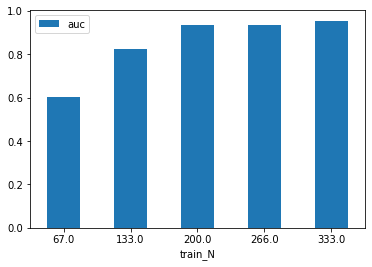

In [13]:
result = pd.read_csv("result_13_10fold_test.csv")
result=result.sort_values('auc', ascending=False).drop_duplicates(['train_N'])
result = result.sort_values('train_N', ascending=True).drop("seed",axis=1)
result.head()
result.plot.bar(x='train_N', y='auc', rot=0)
plt.savefig('result_13_auc_vs_sample.pdf')